In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np
np.random.seed(0)
import pandas as pd
import gc, os, time
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold

import pickle

pd.set_option('display.max_columns',999)

from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
sns.set_style('dark')

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [2]:
# 학습용 데이터 
train_sensor = pd.read_csv('train_sensor.csv')
train_quality = pd.read_csv('train_quality.csv')
# 평가용 데이터 
predict_sensor = pd.read_csv('predict_sensor.csv')

In [3]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    ''' column을 param_alias 로만 pivot table 만들기. '''
    df_X = X.copy()
    df_X = df_X.sort_values(by='end_time',ascending=True)
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성합니다. ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정합니다. 
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    ''' step별 end_time을 column으로 pivot table 만들기 '''
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])
    # end_time 은 센서 데이터가 각 para 별로 서버에 도달한 시간으로 스텝 내 오차가 발생할 수 있습니다. 동일 스텝 구간내 공정 완료 시간이 다른 경우, min 함수를 사용하여 최초 수집된 time을 가져옵니다.
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : min(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete.rename(columns={'index':'key_val'},inplace=True)
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합합니다.
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        # 컬럼 이름을 변경합니다.  
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)
        df_complete.rename(columns={'index':'key_val'},inplace=True)


    # 컬럼 순서를 정렬합니다. 
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    # 처음 step이 시작된 시점을 기준으로 다시 정렬(APC value를 먹고 들어가는 값을 기준으로 정렬하고 싶었음.)
    df_complete = df_complete.set_index(['module_name','key_val','04_end_time']).sort_index(level=[0,2,1],ascending=True).reset_index()
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경합니다. 
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete

# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

In [4]:
print(len(train.columns))
print(len(predict.columns))

676
674


In [5]:
# 전체 및 개별 공정 소요시간 변수를 생성하는 함수입니다.
def gen_tmdiff(df, lst_stepsgap):
    df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()
    for stepgap in lst_stepsgap:
        df[f'gen_tmdiff_{stepgap}'] = (df[f'{stepgap[2:]}_end_time'] - df[f'{stepgap[:2]}_end_time']).dt.total_seconds()
    return df

# 4. 데이터 전처리

In [6]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_train = train.copy()
df_predict = predict.copy()

In [7]:
# 센서 컬럼과 날짜 컬럼을 정의합니다. 
col_sensor = df_train.iloc[:, 4:-7].columns.tolist() 
col_time = df_train.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의합니다. 
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']

''' step별로 fdc para명 따로 수집 '''
lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
df_train[col_time] = df_train[col_time].apply(pd.to_datetime)

In [8]:
df_train = gen_tmdiff(df_train, lst_stepsgap)
df_predict = gen_tmdiff(df_predict, lst_stepsgap)
df_train.filter(regex='tmdiff').head(2)

,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820
0,1912.0,146.0,846.0,16.0,477.0,16.0,411.0
1,1911.0,145.0,847.0,16.0,476.0,16.0,411.0


In [9]:
df_train.drop(['gen_tmdiff_1213','gen_tmdiff_1718'], axis=1, inplace=True)
df_predict.drop(['gen_tmdiff_1213','gen_tmdiff_1718'], axis=1, inplace=True)

In [10]:
for_col_filter = []
for para in sensors_nm:
    for_col_filter.append(para.split('_')[0])
for_col_filter = list(set(for_col_filter))
for_col_filter

['temp',
 'tmp',
 'epd',
 'efem',
 'fr',
 'he',
 'time',
 'pressure',
 'gas',
 'esc',
 'hv',
 'power',
 'position']

In [11]:
''' CATEGORY 변수 처리 및 NUM FEATURE 정의 '''
module2idx = {}
for i, module in enumerate(df_train['module_name'].unique()):
    module2idx[module] = i
    
def col2cat(df, col, dict):
    df[col] = df[col].apply(lambda x: dict[x])
    df[col] = df[col].astype('category')
    return df[col]

# module_name cat 화
col2cat(df_train, 'module_name', module2idx)
col2cat(df_predict, 'module_name', module2idx)

0       0
1       0
2       0
3       0
4       0
       ..
257    45
258    46
259    46
260    46
261    46
Name: module_name, Length: 262, dtype: category
Categories (47, int64): [0, 1, 2, 3, ..., 43, 44, 45, 46]

In [12]:
# 우선 단일 columns 제거.
unique_col = df_train.loc[:,df_train.nunique()==1].columns.tolist()
df_train.drop(unique_col, axis=1, inplace=True)
df_predict.drop(unique_col, axis=1, inplace=True)

# EFEM PARA 삭제

In [13]:
efem_cols = df_train.filter(regex='efem').columns.tolist()
df_train.drop(efem_cols, axis=1, inplace=True)
df_predict.drop(efem_cols, axis=1, inplace=True)

# GAS 전처리

In [14]:
gas_ = []
for para in df_train.filter(regex='gas').columns.tolist():
    gas_.append(para.split('_')[1]+'_'+para.split('_')[2])
gas_ = sorted(list(set(gas_)))

<Figure size 1440x2016 with 0 Axes>

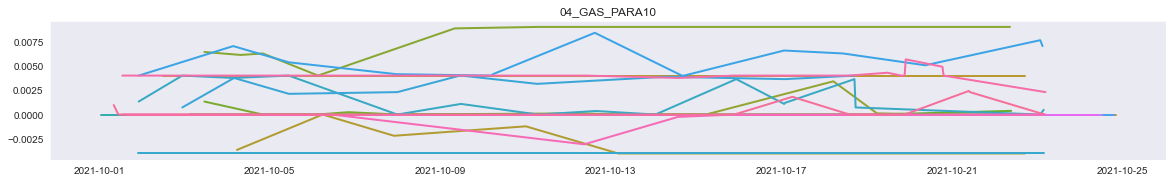

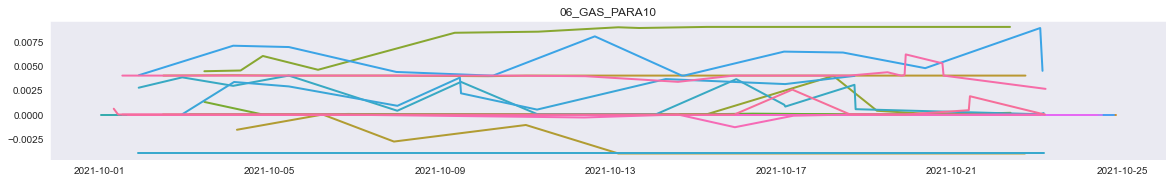

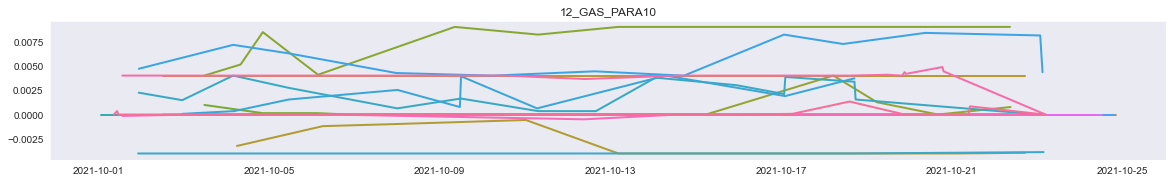

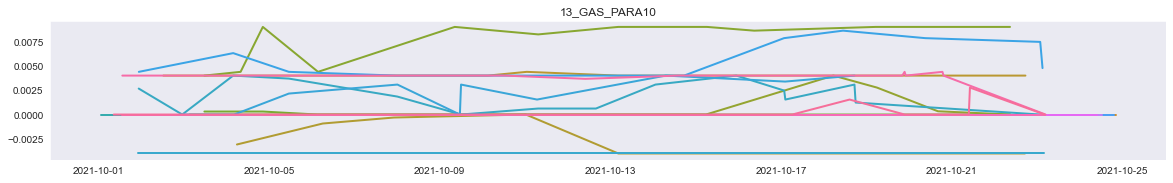

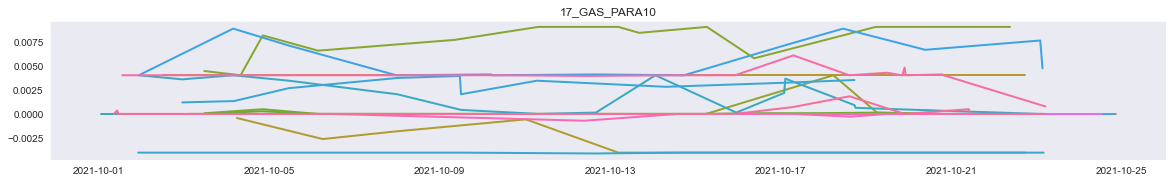

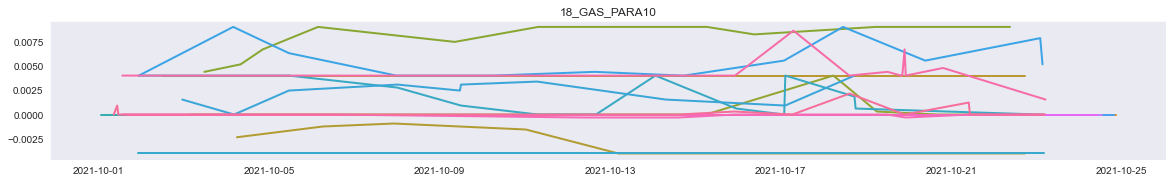

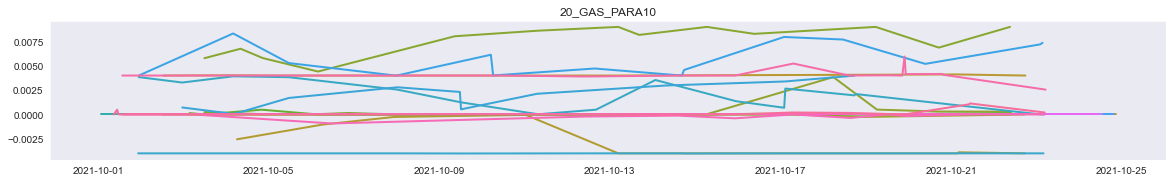

<Figure size 1440x2016 with 0 Axes>

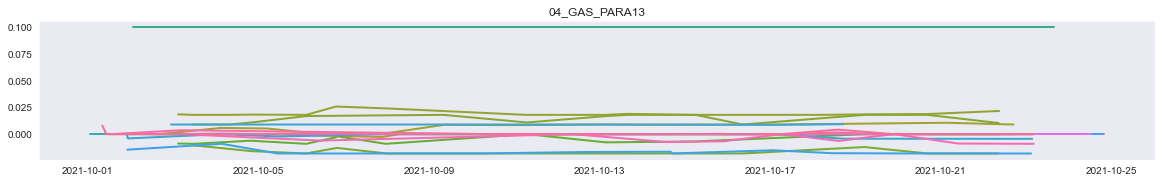

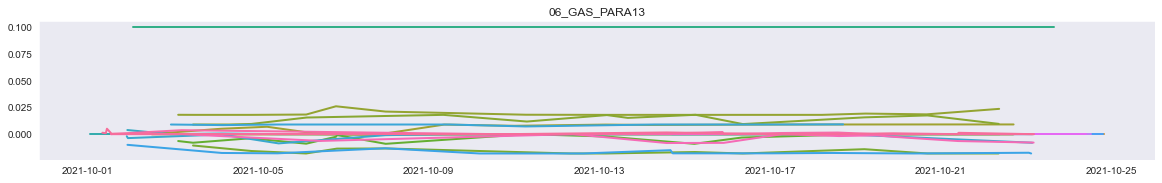

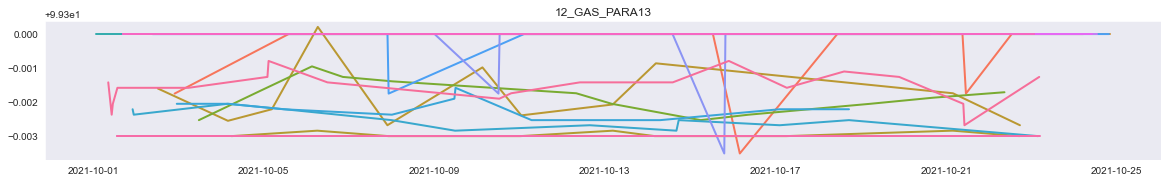

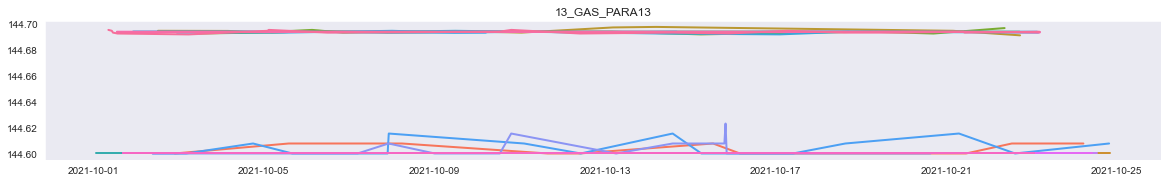

KeyboardInterrupt: 

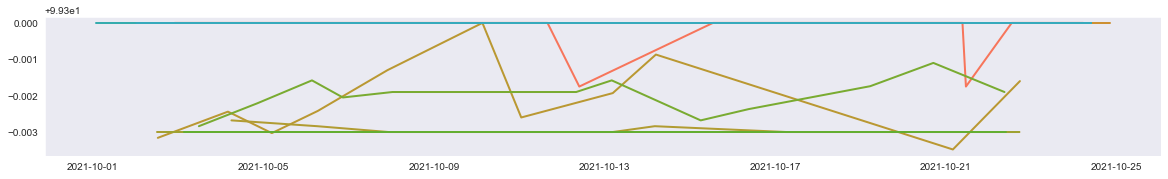

In [15]:
''' 시각화 '''
for filterp in gas_:
    paras = df_train.filter(regex=filterp+'$').columns.tolist()
    n_cols = len(paras)
    fig = plt.figure(figsize=(20,4*n_cols))
    for i,para in enumerate(paras):
        fig = plt.figure(figsize=(20,3*n_cols))
        plt.subplot(n_cols, 1, i+1)
        sns.lineplot(data = df_train, x= para[:2]+'_end_time', y = para, hue='module_name', linewidth = 2, legend=False)
        plt.title(f'{para.upper()}')
#         plt.subplots_adjust(hspace = 1.0)
        plt.ylabel('')
        plt.xlabel('')
        plt.show()
#         print(f'{para.upper()}의 세정 전 RF TIME : {df_train[para].max()}')

In [16]:
# all step 사용하는 gas
PARA21_COL = df_train.filter(regex='gas_para21$').columns.tolist()
PARA36_COL = df_train.filter(regex='gas_para36$').columns.tolist()
PARA6_COL = df_train.filter(regex='gas_para6$').columns.tolist()
ROUND2_GAS_COL = PARA21_COL+PARA36_COL+PARA6_COL+['20_gas_para39','13_gas_para46','18_gas_para46','04_gas_para51']

GAS_COL = df_train.filter(regex='gas').columns.tolist()
GAS_COL = [col for col in GAS_COL if col not in ROUND2_GAS_COL]
df_train.drop(GAS_COL, axis=1, inplace=True)

# TEMP 전처리

In [17]:
temp_ = []
for para in df_train.filter(regex='temp').columns.tolist():
    temp_.append(para.split('_')[1]+'_'+para.split('_')[2])
temp_ = sorted(list(set(temp_)))

In [ ]:
'''시각화'''
for filterp in temp_:
    paras = df_train.filter(regex=filterp+'$').columns.tolist()
    n_cols = len(paras)
    fig = plt.figure(figsize=(20,4*n_cols))
    for i,para in enumerate(paras):
        fig = plt.figure(figsize=(20,3*n_cols))
        plt.subplot(n_cols, 1, i+1)
        sns.lineplot(data = df_train, x= para[:2]+'_end_time', y = para, hue='module_name', linewidth = 2, legend=False, marker='o')
        plt.title(f'{para.upper()}')
#         plt.subplots_adjust(hspace = 1.0)
        plt.ylabel('')
        plt.xlabel('')
        plt.show()
#         print(f'{para.upper()}의 세정 전 RF TIME : {df_train[para].max()}')

In [18]:
ALL_DROP = ['temp_para11', 'temp_para23', 'temp_para32', 'temp_para53', 'temp_para55', 'temp_para79', 'temp_para87', 'temp_para92', 'temp_para93','04_temp_para17', '06_temp_para17']
for col in ALL_DROP:
    cols = df_train.filter(regex=col+'$').columns.tolist()
    df_train.drop(cols,axis=1,inplace=True)
    df_predict.drop(cols,axis=1,inplace=True)

# TIME 전처리

In [19]:
# time_para66이 1도정도 한챔버가 튀었는데, 삭제할지 말지, 처음엔 삭제안한게 더 높았는데, 모델수정 후에는 삭제한게 더 높다.
time66 = df_train.filter(regex='time_para66$').columns.tolist()
df_train.drop(time66, axis=1, inplace=True)
df_predict.drop(time66, axis=1, inplace=True)

In [20]:
df = df_train.filter(regex='time').drop(df_train.filter(regex='end_time$').columns.tolist(), axis=1)
time_para = []
for col in df.columns:
    time_para.append(col[3:])
time_para = sorted(list(set(time_para)))
time_para.remove('time_para5')    # 나중에 처리.

In [ ]:
''' 시각화 '''
for filterp in time_para:
    paras = df.filter(regex=filterp+'$').columns.tolist()
    n_cols = len(paras)
    fig = plt.figure(figsize=(20,4*n_cols))
    for i,para in enumerate(paras):
        fig = plt.figure(figsize=(20,3*n_cols))
        plt.subplot(n_cols, 1, i+1)
        sns.lineplot(data = df_train, x= para[:2]+'_end_time', y = para, hue='module_name', linewidth = 2, legend=False)
        plt.axhline(df_train[para].max(), color='r',linewidth=2)
        plt.title(f'{para.upper()}')
#         plt.subplots_adjust(hspace = 1.0)
        plt.ylabel('')
        plt.xlabel('')
        plt.show()
        print(f'{para.upper()}의 세정 전 RF TIME : {df_train[para].max()}')

In [21]:
# 우선 RF TIME이 쭉 떨어진 애들만 COL만들기
for para in time_para:
    col = f'04_{para}'
    tmp_train = df_train.groupby('module_name')[col].shift(1).fillna(0)
    tmp_predict = df_predict.groupby('module_name')[col].shift(1).fillna(0)
    df_train[f'tmp_{para}'] = df_train[col]-tmp_train
    df_predict[f'tmp_{para}'] = df_predict[col]-tmp_predict
    df_train.loc[:, f'CLN_DAY_{para}'] = df_train[f'tmp_{para}'].apply(lambda x: 1 if x<=0 else 0)   # 전체 dataset에 대해서 처리돼있는 df,
    df_predict.loc[:, f'CLN_DAY_{para}'] = df_predict[f'tmp_{para}'].apply(lambda x: 1 if x<=0 else 0)
df_train.drop(df_train.filter(regex='^tmp').columns.tolist(), axis=1, inplace=True)
df_predict.drop(df_predict.filter(regex='^tmp').columns.tolist(), axis=1, inplace=True)

In [22]:
print('CLN columns added to TRAIN DATASET : {}'.format(len(df_train.filter(regex='^CLN').columns)))
print('CLN columns added to PREDICT DATASET: {}'.format(len(df_predict.filter(regex='^CLN').columns)))
df_train.filter(regex='^CLN').head(3)

CLN columns added to TRAIN DATASET : 21
CLN columns added to PREDICT DATASET: 21


,CLN_DAY_time_para16,CLN_DAY_time_para29,CLN_DAY_time_para30,CLN_DAY_time_para34,CLN_DAY_time_para37,CLN_DAY_time_para41,CLN_DAY_time_para42,CLN_DAY_time_para43,CLN_DAY_time_para44,CLN_DAY_time_para62,CLN_DAY_time_para64,CLN_DAY_time_para67,CLN_DAY_time_para7,CLN_DAY_time_para75,CLN_DAY_time_para77,CLN_DAY_time_para8,CLN_DAY_time_para81,CLN_DAY_time_para83,CLN_DAY_time_para89,CLN_DAY_time_para9,CLN_DAY_time_para90
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 두줄 트렌드 TEST COL 추가

In [23]:
df_train['06_epd_para4_test'] = df_train['06_epd_para4'].apply(lambda x: 1 if x > 50 else 0)
df_train['20_epd_para4_test'] = df_train['20_epd_para4'].apply(lambda x: 1 if x < 900 else 0)
df_train['04_hv_para45_test'] = df_train['04_hv_para45'].apply(lambda x: 1 if x < 150 else 0)
df_train['04_hv_para47_test'] = df_train['04_hv_para47'].apply(lambda x: 1 if x < 80 else 0)
df_train['04_hv_para56_test'] = df_train['04_hv_para56'].apply(lambda x: 1 if x < 0.1 else 0)
df_train['06_power_para57_test'] = df_train['06_power_para57'].apply(lambda x: 1 if x > 2250 else 0)
df_train['06_power_para76_test'] = df_train['06_power_para76'].apply(lambda x: 1 if x > 1600 else 0)

df_predict['06_epd_para4_test'] = df_predict['06_epd_para4'].apply(lambda x: 1 if x > 50 else 0)
df_predict['20_epd_para4_test'] = df_predict['20_epd_para4'].apply(lambda x: 1 if x < 900 else 0)
df_predict['04_hv_para45_test'] = df_predict['04_hv_para45'].apply(lambda x: 1 if x < 150 else 0)
df_predict['04_hv_para47_test'] = df_predict['04_hv_para47'].apply(lambda x: 1 if x < 100 else 0)
df_predict['04_hv_para56_test'] = df_predict['04_hv_para56'].apply(lambda x: 1 if x < 0.1 else 0)
df_predict['06_power_para57_test'] = df_predict['06_power_para57'].apply(lambda x: 1 if x > 2300 else 0)
df_predict['06_power_para76_test'] = df_predict['06_power_para76'].apply(lambda x: 1 if x > 1600 else 0)

''' 5000 이상은 1, 아래는 0으로인코딩 '''
time_5000 = ['time_para16','time_para42','time_para43','time_para44','time_para62','time_para75','time_para77','time_para89']
CLN_COLS = df_train.filter(regex='^CLN').columns.tolist()
for col in time_5000:
    col_ = df_train.filter(regex=col+'$').columns.tolist()
    col_ = [x for x in col_ if x not in CLN_COLS]    # filter된 col 중 CLN col 제외.
    for column in col_:
        df_train[column+'_test'] = df_train[column].apply(lambda x: 1 if x>5000 else 0)
        df_predict[column+'_test'] = df_predict[column].apply(lambda x: 1 if x>5000 else 0)
        
''' TIME PARA5 처리 / 125 이상은 0, 아래는 1로 인코딩(데이터수가 많은 걸 BASE(0)으로.) '''
time_125 = ['12_time_para5','13_time_para5','17_time_para5','18_time_para5']
for col in time_125:
    df_train[col+'_test'] = df_train[col].apply(lambda x: 1 if x <125 else 0)
    df_predict[col+'_test'] = df_predict[col].apply(lambda x: 1 if x <125 else 0)
    
''' 2.6 이상 1, 아래 0 '''
'04_tmp_para31'
df_train['04_tmp_para31_test'] = df_train['04_tmp_para31'].apply(lambda x: 1 if x >=2.6 else 0)
df_predict['04_tmp_para31_test'] = df_predict['04_tmp_para31'].apply(lambda x: 1 if x >=2.6 else 0)
''' 2.8 이상 1, 아래 0 '''
'06_tmp_para31'
df_train['06_tmp_para31_test'] = df_train['06_tmp_para31'].apply(lambda x: 1 if x >=2.8 else 0)
df_predict['06_tmp_para31_test'] = df_predict['06_tmp_para31'].apply(lambda x: 1 if x >=2.8 else 0)
''' 4.0 이상 1, 아래 0 '''
tmp_4 = ['12_tmp_para31','13_tmp_para31','17_tmp_para31','18_tmp_para31','20_tmp_para31']
for col in tmp_4:
    df_train[col+'_test'] = df_train[col].apply(lambda x: 1 if x>=4.0 else 0)
    df_predict[col+'_test'] = df_predict[col].apply(lambda x: 1 if x>=4.0 else 0)

# 수치 단순화하기

In [24]:
# np.round 하기
TIME5_COL = df_train.filter(regex='time_para5$').columns.tolist()
TOT_TCOL = df_train.filter(regex='time').loc[:,df_train.filter(regex='time').dtypes==float].columns.tolist()
TOT_TCOL = [col for col in TOT_TCOL if col not in TIME5_COL]
df_train.loc[:, TOT_TCOL] = np.round(df_train[TOT_TCOL],0)    # TIME PARA5를 제외한 나머지만 round(0)
df_predict.loc[:, TOT_TCOL] = np.round(df_predict[TOT_TCOL],0)

df_train.loc[:, ROUND2_GAS_COL] = np.round(df_train[ROUND2_GAS_COL],2)
df_predict.loc[:, ROUND2_GAS_COL] = np.round(df_predict[ROUND2_GAS_COL],2)

num_features = df_train.columns[df_train.dtypes==float].tolist()
num_features.remove('y')
num_features = [col for col in num_features if col not in ROUND2_GAS_COL]
df_train.loc[:,num_features] = np.round(df_train[num_features],1)    # TIME PARA는 round(1), TEMP도 round(1)
df_predict.loc[:,num_features] = np.round(df_predict[num_features],1)

# Cyclic Transformation 적용

In [25]:
def cyclic_transformation(df, cols):
    for col in cols:
        step = col[:2]
        df[col] = pd.to_datetime(df[col])
        df[step+'_'+'hour'] = df[col].dt.hour
        df[step+'_'+'month'] = df[col].dt.month
        df[step+'_'+'day'] = df[col].dt.day
        df[step+'_'+'weekday'] = df[col].dt.weekday
        
        ## cyclic transformation on hour
        df[step+'_'+'hour_sin'] = np.sin(2 * np.pi * df[step+'_'+'hour']/23.0)
        df[step+'_'+'hour_cos'] = np.cos(2 * np.pi * df[step+'_'+'hour']/23.0)
        ## cyclic transformation on date 
        df[step+'_'+'date_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        df[step+'_'+'date_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        ## cyclic transformation on month
        df[step+'_'+'month_sin'] = -np.sin(2 * np.pi * df[step+'_'+'month']/12.0)
        df[step+'_'+'month_cos'] = -np.cos(2 * np.pi * df[step+'_'+'month']/12.0)
        ## cyclic transformation on weekday
        df[step+'_'+'weekday_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        df[step+'_'+'weekday_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)

In [26]:
endtime_col = df_train.filter(regex='04_end_time$').columns.tolist()
cyclic_transformation(df_train, endtime_col)
cyclic_transformation(df_predict, endtime_col)

In [26]:
df_train.head(1)

,module_name,key_val,end_dt_tm,y,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para21,04_gas_para36,04_gas_para51,04_gas_para6,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para12,04_temp_para18,04_temp_para20,04_temp_para38,04_temp_para54,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para86,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para21,06_gas_para36,06_gas_para6,06_he_para22,06_he_para88,06_he_para95,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para12,06_temp_para18,06_temp_para20,06_temp_para38,06_temp_para54,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para86,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para21,12_gas_para36,12_gas_para6,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para24,12_temp_para38,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para86,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_esc_para84,13_esc_para94,13_fr_para28,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para21,13_gas_para36,13_gas_para46,13_gas_para6,13_he_para22,13_he_para88,13_hv_para3,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para57,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para12,13_temp_para17,13_temp_para18,13_temp_para20,13_temp_para24,13_temp_para38,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para86,13_time_para16,13_time_para29,13_time_para30,13_time_para34,13_time_para37,13_time_para41,13_time_para42,13_time_para43,13_time_para44,13_time_para5,13_time_para62,13_time_para64,13_time_para67,13_time_para7,13_time_para75,13_time_para77,13_time_para8,13_time_para81,13_time_para83,13_time_para89,13_time_para9,13_time_para90,13_tmp_para31,17_esc_para84,17_esc_para94,17_fr_para28,17_fr_para35,17_fr_para61,17_fr_para69,17_gas_para21,17_gas_para36,17_gas_para6,17_he_para22,17_he_para88,17_hv_para3,17_hv_para45,17_hv_para47,17_hv_para56,17_position_para72,17_power_para14,17_power_para57,17_power_para76,17_power_para82,17_pressure_para91,17_temp_para12,17_temp_para17,17_temp_para18,17_temp_para20,17_temp_para24,17_temp_para38,17_temp_para58,17_temp_para60,17_temp_para65,17_temp_para66,17_temp_para86,17_time_para16,17_time_para29,17_time_para30,17_time_para34,17_time_para37,17_time_para41,17_time_para42,17_time_para43,17_time_para44,17_time_para5,17_time_para62,17_time_para64,17_time_para67,17_time_para7,17_time_para75,17_time_para77,17_time_para8,17_time_para81,17_time_para83,17_time_para89,17_time_para9,17_time_para90,17_tmp_para31,18_e

In [27]:
df_predict.head(1)

,module_name,key_val,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para12,04_temp_para18,04_temp_para20,04_temp_para38,04_temp_para54,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para86,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para22,06_he_para88,06_he_para95,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para12,06_temp_para18,06_temp_para20,06_temp_para38,06_temp_para54,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para86,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para24,12_temp_para38,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para86,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_esc_para84,13_esc_para94,13_fr_para28,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para10,13_gas_para13,13_gas_para15,13_gas_para19,13_gas_para21,13_gas_para26,13_gas_para27,13_gas_para33,13_gas_para36,13_gas_para39,13_gas_para46,13_gas_para48,13_gas_para50,13_gas_para51,13_gas_para52,13_gas_para59,13_gas_para6,13_gas_para70,13_gas_para71,13_gas_para73,13_gas_para74,13_gas_para85,13_he_para22,13_he_para88,13_hv_para3,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para57,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para12,13_temp_para17,13_temp_para18,13_temp_para20,13_temp_para24,13_temp_para38,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para86,13_time_para16,13_time_para29,13_time_para30,13_time_para34,13_time_para37,13_time_para41,13_time_para42,13_time_para43,13_ti

# 모델링 진행

In [27]:
df_final = df_train.copy()
df_predict_final = df_predict.copy()

In [28]:
''' 중복열 제거 step, para number 상관없이. '''
drop_col = []
for para in for_col_filter+['CLN']:
    col = df_final.filter(regex=para).columns.tolist()
    if col:
        duplicate_deleted_df = df_final[col].T.drop_duplicates(subset=df_final[col].T.columns, keep='first').T
        if len(df_final[col].columns.difference(duplicate_deleted_df.columns))==0:  # 다른게 없으면 무시,
            continue
        else:
            drop_col.extend(df_final[col].columns.difference(duplicate_deleted_df.columns).tolist())
    else:
        continue
            
# 새로 생성한 TEST COLUMNS 전처리
test_col = df_final.filter(regex='test$').columns.tolist()
duplicate_deleted_test_df = df_final[test_col].T.drop_duplicates(subset=df_final[test_col].T.columns, keep='first').T
if len(df_final[test_col].columns.difference(duplicate_deleted_test_df.columns))!=0:
    drop_col.extend(df_final[test_col].columns.difference(duplicate_deleted_test_df.columns).tolist())
    
drop_col = list(set(drop_col))
df_final.drop(drop_col, axis=1, inplace=True)
df_predict_final.drop(drop_col, axis=1, inplace=True)
print(f'중복돼 제거된 COLUMNS : {drop_col}')

var0_col = df_final.loc[:,df_final.nunique()==1].columns.tolist()
df_final.drop(var0_col, axis=1, inplace=True)
df_predict_final.drop(var0_col, axis=1, inplace=True)

for i in range(47):
    trains = df_final[df_final['module_name']==i]
    predicts = df_predict_final[df_predict_final['module_name']==i]
    ''' CLN_DAY COLUMN들 마지막 1을 기준으로 0,1 인코딩 '''
    for col in trains.filter(regex='^CLN').columns.tolist():
        if col:
            if trains[trains[col]==1].index.tolist():
                if predicts[predicts[col]==1].index.tolist():
                    CLN_INDEX_TRAIN = trains[trains[col]==1].index[-1]    # 마지막 index를 기준으로, 
                    CLN_INDEX_PREDICT = predicts[predicts[col]==1].index[-1]
                    trains.loc[:CLN_INDEX_TRAIN-1, col] = 0
                    trains.loc[CLN_INDEX_TRAIN:, col] = 1
                    predicts.loc[:CLN_INDEX_PREDICT-1, col] = 0
                    predicts.loc[CLN_INDEX_PREDICT:, col] = 1
                    df_final[df_final['module_name']==i] = trains
                    df_predict_final[df_predict_final['module_name']==i] = predicts
                else:
                    CLN_INDEX_TRAIN = trains[trains[col]==1].index[-1]
                    trains.loc[:CLN_INDEX_TRAIN-1, col] = 0
                    trains.loc[CLN_INDEX_TRAIN:, col] = 1
                    df_final[df_final['module_name']==i] = trains
            else:
                continue
        else:
            continue


중복돼 제거된 COLUMNS : ['06_tmp_para31_test', '18_time_para44_test', '04_hv_para45_test', '17_time_para43_test', '13_time_para83', '13_time_para8', '13_time_para37', '18_time_para62', '06_power_para76_test', '12_time_para5_test', '18_time_para64', '20_time_para16_test', '18_time_para90', '18_time_para16', '13_time_para64', '18_time_para29', '04_hv_para56_test', '17_time_para89_test', '13_time_para29', '18_time_para5_test', '13_time_para43_test', '18_time_para62_test', '06_he_para95', '13_time_para5', '13_time_para43', '18_time_para16_test', '17_time_para16_test', '20_time_para62_test', '06_time_para16_test', '06_time_para62_test', '18_time_para7', '13_tmp_para31_test', '17_time_para5', '12_time_para42_test', '04_hv_para47_test', '17_time_para77_test', '13_time_para30', '04_time_para44_test', 'CLN_DAY_time_para77', '06_time_para44_test', '18_time_para44', '18_time_para89_test', '13_time_para16_test', '13_time_para42_test', '13_time_para42', '04_time_para77_test', '13_time_para77', 'CLN_DAY_t

In [29]:
# module name 원핫인코딩
df_final_ohe = pd.concat([df_final, pd.get_dummies(df_final['module_name'], prefix='module_name')],axis=1)
df_predict_final_ohe = pd.concat([df_predict_final, pd.get_dummies(df_predict_final['module_name'], prefix='module_name')],axis=1)
df_final_ohe.drop('module_name', axis=1, inplace=True)
df_predict_final_ohe.drop('module_name', axis=1, inplace=True)
df_final_ohe.head()

,key_val,end_dt_tm,y,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para21,04_gas_para36,04_gas_para51,04_gas_para6,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para12,04_temp_para18,04_temp_para20,04_temp_para38,04_temp_para54,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para86,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para21,06_gas_para36,06_gas_para6,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para12,06_temp_para18,06_temp_para20,06_temp_para38,06_temp_para54,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para86,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para21,12_gas_para36,12_gas_para6,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para24,12_temp_para38,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para86,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_esc_para84,13_esc_para94,13_fr_para28,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para21,13_gas_para36,13_gas_para46,13_gas_para6,13_he_para22,13_he_para88,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para57,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para12,13_temp_para17,13_temp_para18,13_temp_para20,13_temp_para24,13_temp_para38,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para86,13_tmp_para31,17_esc_para84,17_esc_para94,17_fr_para28,17_fr_para35,17_fr_para61,17_fr_para69,17_gas_para21,17_gas_para36,17_gas_para6,17_he_para22,17_he_para88,17_hv_para3,17_hv_para45,17_hv_para47,17_hv_para56,17_position_para72,17_power_para14,17_power_para57,17_power_para76,17_power_para82,17_temp_para12,17_temp_para17,17_temp_para18,17_temp_para20,17_temp_para24,17_temp_para38,17_temp_para58,17_temp_para60,17_temp_para65,17_temp_para66,17_temp_para86,17_time_para16,17_time_para29,17_time_para30,17_time_para34,17_time_para37,17_time_para41,17_time_para42,17_time_para43,17_time_para44,17_time_para62,17_time_para64,17_time_para67,17_time_para7,17_time_para75,17_time_para77,17_time_para8,17_time_para81,17_time_para83,17_time_para89,17_time_para9,17_time_para90,17_tmp_para31,18_esc_para84,18_esc_para94,18_fr_para28,18_fr_para35,18_fr_para61,18_fr_para69,18_gas_para21,18_gas_para36,18_gas_para46,18_gas_para6,18_he_para22,18_he_para88,18_hv_para3,18_hv_para45,18_hv_para47,18_hv_para56,18_position_para72,18_power_para14,18_power_para57,18_power_para68,18_power_para76,18_power_para82,18_pressure_para91,18_temp_para12,18_temp_para17,18_temp_para18,18_temp_para20,18_temp_para24,18_temp_para38,18_temp_para

In [30]:
''' Cyclic Transformation 된 time만 사용. gen+float f들 '''
num_features = list(df_final.columns[df_final.dtypes==float])
num_features.remove('y')
CLN_COLS = df_final.filter(regex='^CLN').columns.tolist()
TEST_COLS = df_final.filter(regex='test$').columns.tolist()
MODULE_ohe = df_final_ohe.filter(regex='^module_name').columns.tolist()
CAT_FEATURES = ['module_name']

# CAT 용
COLS = CAT_FEATURES + num_features + CLN_COLS + TEST_COLS

# XGB 용
COLS_ohe = MODULE_ohe + num_features + CLN_COLS + TEST_COLS

# 모델링

In [31]:
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score

import optuna
from optuna.samplers import TPESampler

In [32]:
df_final[COLS].head()

,module_name,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para21,04_gas_para36,04_gas_para51,04_gas_para6,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para12,04_temp_para18,04_temp_para20,04_temp_para38,04_temp_para54,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para86,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para21,06_gas_para36,06_gas_para6,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para12,06_temp_para18,06_temp_para20,06_temp_para38,06_temp_para54,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para86,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para21,12_gas_para36,12_gas_para6,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para24,12_temp_para38,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para86,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_esc_para84,13_esc_para94,13_fr_para28,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para21,13_gas_para36,13_gas_para46,13_gas_para6,13_he_para22,13_he_para88,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para57,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para12,13_temp_para17,13_temp_para18,13_temp_para20,13_temp_para24,13_temp_para38,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para86,13_tmp_para31,17_esc_para84,17_esc_para94,17_fr_para28,17_fr_para35,17_fr_para61,17_fr_para69,17_gas_para21,17_gas_para36,17_gas_para6,17_he_para22,17_he_para88,17_hv_para3,17_hv_para45,17_hv_para47,17_hv_para56,17_position_para72,17_power_para14,17_power_para57,17_power_para76,17_power_para82,17_temp_para12,17_temp_para17,17_temp_para18,17_temp_para20,17_temp_para24,17_temp_para38,17_temp_para58,17_temp_para60,17_temp_para65,17_temp_para66,17_temp_para86,17_time_para16,17_time_para29,17_time_para30,17_time_para34,17_time_para37,17_time_para41,17_time_para42,17_time_para43,17_time_para44,17_time_para62,17_time_para64,17_time_para67,17_time_para7,17_time_para75,17_time_para77,17_time_para8,17_time_para81,17_time_para83,17_time_para89,17_time_para9,17_time_para90,17_tmp_para31,18_esc_para84,18_esc_para94,18_fr_para28,18_fr_para35,18_fr_para61,18_fr_para69,18_gas_para21,18_gas_para36,18_gas_para46,18_gas_para6,18_he_para22,18_he_para88,18_hv_para3,18_hv_para45,18_hv_para47,18_hv_para56,18_position_para72,18_power_para14,18_power_para57,18_power_para68,18_power_para76,18_power_para82,18_pressure_para91,18_temp_para12,18_temp_para17,18_temp_para18,18_temp_para20,18_temp_para24,18_temp_para38,18_temp_para58,18_te

In [48]:
# LGB
def objective_LGB(trial):
    param_lgb = {
            'objective':'regression',
            'metric':'rmse',
            "random_state":42,
            'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5, step=0.01),
#             "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 4e-5),
#             "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'feature_fraction' :trial.suggest_float('feature_fraction', 0.1, 1.0, step=0.1),
            "n_estimators":trial.suggest_int("n_estimators", 100, 2000, step=10),
            "max_depth":-1,
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "max_bin": trial.suggest_int("max_bin", 100, 500)
    }
    X = df_final[COLS]
    y = df_final['y']

    model = lgb.LGBMRegressor(**param_lgb, categorical_feature=0)
    cv = KFold(11, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmsle_val = np.mean(scores)
     
    return rmsle_val
    
sampler = TPESampler(seed=42)
study_lgb = optuna.create_study(
                study_name="lgb_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
study_lgb.optimize(objective_LGB, n_trials=30)
print("Best Score:", study_lgb.best_value)
print("Best trial:", study_lgb.best_trial.params)
    
model_lgb = lgb.LGBMRegressor(**study_lgb.best_params, objective='regression', metric='rmse', random_state=42, categorical_feature=0)
model_lgb.fit(df_final[COLS], df_final['y'])
print('model training is completed')

[I 2022-07-26 22:27:52,668] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGB

[I 2022-07-26 22:28:53,385] Trial 0 finished with value: 6.9984238779720185 and parameters: {'learning_rate': 0.19, 'feature_fraction': 1.0, 'n_estimators': 1490, 'min_child_samples': 14, 'max_bin': 162}. Best is trial 0 with value: 6.9984238779720185.


CV scores : [7.31944466 6.92755201 7.48374331 7.53556563 6.60749706 6.32415241
 7.04440305 6.71564625 6.95231701 6.86803942 7.20430184]
Mean score :  6.9984238779720185
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored.

[I 2022-07-26 22:29:31,699] Trial 1 finished with value: 7.141063427789326 and parameters: {'learning_rate': 0.08, 'feature_fraction': 0.1, 'n_estimators': 1750, 'min_child_samples': 14, 'max_bin': 383}. Best is trial 0 with value: 6.9984238779720185.


CV scores : [7.56516344 7.34852201 6.78804437 7.57976813 7.15027864 6.91553506
 7.45543173 6.91240864 7.21576588 6.97069713 6.65008268]
Mean score :  7.141063427789326
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. 

[I 2022-07-26 22:30:51,201] Trial 2 finished with value: 6.970674373389492 and parameters: {'learning_rate': 0.02, 'feature_fraction': 1.0, 'n_estimators': 1680, 'min_child_samples': 8, 'max_bin': 172}. Best is trial 2 with value: 6.970674373389492.


CV scores : [7.25587591 6.87726147 6.98889352 7.02420726 6.93438243 6.74494831
 7.35121149 6.39601774 7.16573949 6.79327484 7.14560565]
Mean score :  6.970674373389492
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. 

[I 2022-07-26 22:31:25,575] Trial 3 finished with value: 6.996686242747047 and parameters: {'learning_rate': 0.09999999999999999, 'feature_fraction': 0.4, 'n_estimators': 1100, 'min_child_samples': 11, 'max_bin': 216}. Best is trial 2 with value: 6.970674373389492.


CV scores : [7.35539702 6.923442   7.04367053 7.04941084 6.88267962 7.0328189
 7.42643239 6.78683835 7.08043162 6.55619387 6.82623355]
Mean score :  6.996686242747047
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. C

[I 2022-07-26 22:31:43,450] Trial 4 finished with value: 7.332135156614195 and parameters: {'learning_rate': 0.31, 'feature_fraction': 0.2, 'n_estimators': 650, 'min_child_samples': 10, 'max_bin': 282}. Best is trial 2 with value: 6.970674373389492.


CV scores : [7.75544787 7.44885807 7.04395959 7.78524657 7.37731345 7.80882042
 7.27466638 6.61311409 7.49074276 7.11981048 6.93550704]
Mean score :  7.332135156614195
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. 

[I 2022-07-26 22:32:09,919] Trial 5 finished with value: 7.542152229831694 and parameters: {'learning_rate': 0.4, 'feature_fraction': 0.2, 'n_estimators': 1080, 'min_child_samples': 14, 'max_bin': 118}. Best is trial 2 with value: 6.970674373389492.


CV scores : [7.7789226  8.18056127 7.74369374 7.49435624 6.92958499 8.19221651
 8.29857858 6.44501037 7.84634199 6.44881198 7.60559627]
Mean score :  7.542152229831694
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. 

[I 2022-07-26 22:32:14,064] Trial 6 finished with value: 7.232610372356962 and parameters: {'learning_rate': 0.31, 'feature_fraction': 0.2, 'n_estimators': 220, 'min_child_samples': 20, 'max_bin': 487}. Best is trial 2 with value: 6.970674373389492.


CV scores : [7.08128989 7.51844229 7.02186508 8.08604    7.39991388 6.62992355
 7.48702041 7.49359664 6.91821799 7.13206919 6.79033517]
Mean score :  7.232610372356962
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. 

[I 2022-07-26 22:32:22,393] Trial 7 finished with value: 7.584434614714323 and parameters: {'learning_rate': 0.41000000000000003, 'feature_fraction': 0.4, 'n_estimators': 280, 'min_child_samples': 15, 'max_bin': 276}. Best is trial 2 with value: 6.970674373389492.


CV scores : [7.81000956 6.9880623  7.30996135 7.52340674 7.30225839 7.62613133
 7.89859888 7.77017266 7.79132758 8.09010503 7.31874694]
Mean score :  7.584434614714323
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. 

[I 2022-07-26 22:32:26,533] Trial 8 finished with value: 6.99196710066015 and parameters: {'learning_rate': 0.06999999999999999, 'feature_fraction': 0.5, 'n_estimators': 160, 'min_child_samples': 19, 'max_bin': 203}. Best is trial 2 with value: 6.970674373389492.


CV scores : [7.18798925 7.04711331 6.81744452 7.11789386 6.98287405 6.53414036
 7.40259622 6.92704786 7.16500208 6.94481398 6.78472262]
Mean score :  6.99196710066015
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. C

[I 2022-07-26 22:33:02,366] Trial 9 finished with value: 7.404032647802296 and parameters: {'learning_rate': 0.34, 'feature_fraction': 0.4, 'n_estimators': 1090, 'min_child_samples': 13, 'max_bin': 174}. Best is trial 2 with value: 6.970674373389492.


CV scores : [7.42137024 7.57067771 7.30866524 7.94471629 6.55385391 7.22225708
 8.2694804  7.78902354 7.09962684 6.8462994  7.41838848]
Mean score :  7.404032647802296
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. 

[I 2022-07-26 22:35:07,179] Trial 10 finished with value: 7.170543370735453 and parameters: {'learning_rate': 0.2, 'feature_fraction': 1.0, 'n_estimators': 1950, 'min_child_samples': 5, 'max_bin': 361}. Best is trial 2 with value: 6.970674373389492.


CV scores : [7.35416184 7.48033172 7.28584725 6.96548501 7.29945462 7.28804208
 7.6254759  6.21827261 6.7681742  7.36646863 7.22426322]
Mean score :  7.170543370735453
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.700000000000000

[I 2022-07-26 22:35:40,152] Trial 11 finished with value: 6.9354982661531155 and parameters: {'learning_rate': 0.02, 'feature_fraction': 0.7000000000000001, 'n_estimators': 640, 'min_child_samples': 6, 'max_bin': 219}. Best is trial 11 with value: 6.9354982661531155.


CV scores : [7.3414454  7.18856125 6.74155118 6.81351375 7.01274996 6.87205729
 7.04397551 6.79175062 6.78686907 6.78462749 6.91337941]
Mean score :  6.9354982661531155
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored.

[I 2022-07-26 22:35:56,159] Trial 12 finished with value: 6.934152187876483 and parameters: {'learning_rate': 0.01, 'feature_fraction': 0.8, 'n_estimators': 640, 'min_child_samples': 6, 'max_bin': 120}. Best is trial 12 with value: 6.934152187876483.


CV scores : [7.33884693 7.06356611 6.97953255 6.87875122 7.00830222 6.78396641
 7.08656794 6.59468809 6.8719127  6.8047265  6.86481339]
Mean score :  6.934152187876483
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. 

[I 2022-07-26 22:36:12,571] Trial 13 finished with value: 6.896137696351209 and parameters: {'learning_rate': 0.01, 'feature_fraction': 0.8, 'n_estimators': 650, 'min_child_samples': 5, 'max_bin': 101}. Best is trial 13 with value: 6.896137696351209.


CV scores : [7.42407472 7.14271836 7.04125247 6.7066282  6.95771696 6.57495055
 6.90733325 6.32483484 6.8410828  6.96469664 6.97222586]
Mean score :  6.896137696351209
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. 

[I 2022-07-26 22:36:26,723] Trial 14 finished with value: 7.139745905610147 and parameters: {'learning_rate': 0.16, 'feature_fraction': 0.8, 'n_estimators': 640, 'min_child_samples': 7, 'max_bin': 105}. Best is trial 13 with value: 6.896137696351209.


CV scores : [7.28709377 7.31716274 7.3709037  7.19166275 7.03558974 7.14688924
 6.88626851 7.50288097 7.15568076 6.81279448 6.8302783 ]
Mean score :  7.139745905610147
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. 

[I 2022-07-26 22:36:37,400] Trial 15 finished with value: 7.775458450652613 and parameters: {'learning_rate': 0.49, 'feature_fraction': 0.8, 'n_estimators': 460, 'min_child_samples': 9, 'max_bin': 101}. Best is trial 13 with value: 6.896137696351209.


CV scores : [8.00752876 8.12436969 7.0057262  7.9363161  8.16947451 8.32388675
 8.54083089 6.98551303 6.86965813 7.25310078 8.31363811]
Mean score :  7.775458450652613
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] feature_fraction is set=0.700000000000000

[I 2022-07-26 22:36:58,854] Trial 16 finished with value: 6.990258572629269 and parameters: {'learning_rate': 0.13, 'feature_fraction': 0.7000000000000001, 'n_estimators': 830, 'min_child_samples': 5, 'max_bin': 367}. Best is trial 13 with value: 6.896137696351209.


CV scores : [7.39864844 7.0235713  6.8055884  6.88453978 7.22544676 6.82445095
 7.15921605 6.6475726  7.07125978 7.13304975 6.71950048]
Mean score :  6.990258572629269
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. 

[I 2022-07-26 22:37:13,709] Trial 17 finished with value: 6.973072606087157 and parameters: {'learning_rate': 0.01, 'feature_fraction': 0.8, 'n_estimators': 850, 'min_child_samples': 17, 'max_bin': 151}. Best is trial 13 with value: 6.896137696351209.


CV scores : [7.28183853 7.13681523 7.06164403 7.48592394 6.61271644 6.6758879
 7.11660335 6.53695799 6.8334171  6.92284172 7.03915243]
Mean score :  6.973072606087157
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. C

[I 2022-07-26 22:37:48,400] Trial 18 finished with value: 7.163274283242183 and parameters: {'learning_rate': 0.22, 'feature_fraction': 0.6, 'n_estimators': 1440, 'min_child_samples': 7, 'max_bin': 237}. Best is trial 13 with value: 6.896137696351209.


CV scores : [7.07685472 7.98344414 6.74528447 7.55054698 7.41307675 6.87704801
 7.24957686 6.8762182  7.0852786  7.20871175 6.72997664]
Mean score :  7.163274283242183
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


KeyboardInterrupt: 

In [34]:
# save
with open('model_lgb.p', 'wb') as f:
    pickle.dump(model_lgb, f)

# CATBOOST

In [42]:
cat_feautures = [0,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361]
def objective_CAT(trial):
    param_cat = {
          "random_state":42,
          'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.7),
          'bagging_temperature' :trial.suggest_float('bagging_temperature', 1e-4, 100.0),
          "n_estimators":trial.suggest_int("n_estimators", 100, 500),
          "max_depth":trial.suggest_int("max_depth", 4, 16),  # max depth 는 16이 끝.
          'random_strength' :trial.suggest_float('random_strength', 1e-4, 100.0),
          "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.3, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",0,10),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 500),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
#           'iterations':trial.suggest_int("iterations", 50, 200),
#           'task_type':'GPU',
#           'devices':'0'
# #           'rsm':1
    }
    X = df_final[COLS]
    y = df_final['y']
    
    model = CatBoostRegressor(**param_cat,loss_function='RMSE', eval_metric='RMSE', silent=True, cat_features = cat_feautures)
    cv = KFold(5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmse_val = np.mean(scores)

    return rmse_val
    
sampler = TPESampler(seed=42)
study_cat = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
study_cat.optimize(objective_CAT, n_trials=7)
print("Best Score:", study_cat.best_value)
print("Best trial:", study_cat.best_trial.params)
    
model_cat = CatBoostRegressor(**study_cat.best_params,
                            loss_function='RMSE', eval_metric='RMSE',
                            random_state=42, silent=True, cat_features = cat_feautures)
model_cat.fit(df_final[COLS], df_final['y'])
print('model training is completed')

[I 2022-07-26 22:09:24,965] A new study created in memory with name: cat_parameter_opt

KeyboardInterrupt



# XGB
- dart

In [30]:
def objective_XGB(trial):
    param_xgb = {
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01,0.8),
            # defines how selective algorithm is.
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3, 1.0),
            "sample_type": trial.suggest_categorical("sample_type", ["uniform", "weighted"]),
            "normalize_type": trial.suggest_categorical("normalize_type", ["tree", "forest"]),
            "rate_drop": trial.suggest_float("rate_drop", 1e-8, 1.0, log=True),
            "skip_drop": trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    }
        
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = xgb.XGBRegressor(**param_xgb, booster='dart', tree_method='gpu_hist', gpu_id='0', random_state=0)
    cv = KFold(5,shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmsle_val = np.mean(scores)
     
    return rmsle_val
    
sampler = TPESampler(seed=42)
study_xgb = optuna.create_study(
            study_name="xgb_parameter_opt",
            direction="minimize",
            sampler=sampler,
    )
study_xgb.optimize(objective_XGB, n_trials=20, timeout=600)
print("Best Score:", study_xgb.best_value)
print("Best trial:", study_xgb.best_trial.params)
    
model_xgb = xgb.XGBRegressor(**study_xgb.best_params, booster='dart', tree_method='gpu_hist', gpu_id='0', random_state=0)
model_xgb.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-26 19:44:51,225] A new study created in memory with name: xgb_parameter_opt
[I 2022-07-26 19:45:04,183] Trial 0 finished with value: 8.000726145845622 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 956, 'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04566054873446119, 'skip_drop': 4.997040685255803e-07}. Best is trial 0 with value: 8.000726145845622.


CV scores : [7.74545632 8.70847505 8.7493086  7.5818554  7.21853536]
Mean score :  8.000726145845622


[I 2022-07-26 19:45:08,573] Trial 1 finished with value: 8.22503927844458 and parameters: {'reg_lambda': 0.016364255230389386, 'n_estimators': 265, 'max_depth': 6, 'min_child_weight': 6, 'learning_rate': 0.3512365647272715, 'gamma': 2.1371407316372935e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9572205641009174e-07, 'skip_drop': 0.00012997969313168238}. Best is trial 0 with value: 8.000726145845622.


CV scores : [8.44773669 8.89541744 8.89145125 7.31417834 7.57641267]
Mean score :  8.22503927844458


[I 2022-07-26 19:45:11,217] Trial 2 finished with value: 7.692040517046903 and parameters: {'reg_lambda': 0.05331731527343814, 'n_estimators': 141, 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.061390758458370824, 'gamma': 0.39001768308022033, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.469038421774442e-08, 'skip_drop': 9.149877525022172e-05}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.53243039 8.34560539 8.38800922 7.17730059 7.016857  ]
Mean score :  7.692040517046903


[I 2022-07-26 19:45:26,827] Trial 3 finished with value: 7.932740467127198 and parameters: {'reg_lambda': 0.0030949765564844446, 'n_estimators': 919, 'max_depth': 5, 'min_child_weight': 7, 'learning_rate': 0.25625175011063467, 'gamma': 0.00014472520367197597, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006070155694141794, 'skip_drop': 0.23713402899336497}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.9538825  8.62849457 8.56138416 7.05287027 7.46707084]
Mean score :  7.932740467127198


[I 2022-07-26 19:45:29,738] Trial 4 finished with value: 7.880860745623987 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 276, 'max_depth': 3, 'min_child_weight': 4, 'learning_rate': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.9482545946332394e-08, 'skip_drop': 0.7854083114461319}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.67279191 8.86088656 8.17697714 7.26675061 7.42689752]
Mean score :  7.880860745623987


[I 2022-07-26 19:45:32,834] Trial 5 finished with value: 8.236161812208419 and parameters: {'reg_lambda': 0.06950203151425147, 'n_estimators': 279, 'max_depth': 3, 'min_child_weight': 9, 'learning_rate': 0.5684173016396176, 'gamma': 0.006792933207180863, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.4379683310623375e-06, 'skip_drop': 3.224532824812341e-08}. Best is trial 2 with value: 7.692040517046903.


CV scores : [8.60355913 9.04590854 8.62345592 7.64160467 7.26628079]
Mean score :  8.236161812208419


[I 2022-07-26 19:45:42,795] Trial 6 finished with value: 9.240694601965451 and parameters: {'reg_lambda': 0.027988415844586383, 'n_estimators': 392, 'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.710898066635298, 'gamma': 5.994036749692399e-05, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015200666650051572, 'skip_drop': 2.632256136809142e-05}. Best is trial 2 with value: 7.692040517046903.


CV scores : [ 8.80937868 10.14506111  9.89472716  8.63339851  8.72090755]
Mean score :  9.240694601965451


[I 2022-07-26 19:45:44,869] Trial 7 finished with value: 7.833161037591476 and parameters: {'reg_lambda': 0.0022877311527772994, 'n_estimators': 197, 'max_depth': 3, 'min_child_weight': 7, 'learning_rate': 0.25834122505029805, 'gamma': 0.00011710232809812825, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.0797523481449624e-06, 'skip_drop': 1.9488135833929595e-07}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.56865998 8.65081102 8.27593662 7.23027057 7.440127  ]
Mean score :  7.833161037591476


[I 2022-07-26 19:46:05,126] Trial 8 finished with value: 8.888515593773077 and parameters: {'reg_lambda': 0.08367278941385504, 'n_estimators': 828, 'max_depth': 9, 'min_child_weight': 9, 'learning_rate': 0.6449009407503005, 'gamma': 3.108568709174384e-07, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.660108438734075e-07, 'skip_drop': 2.6113333123958975e-05}. Best is trial 2 with value: 7.692040517046903.


CV scores : [8.63526472 9.66527117 9.43389199 8.01554146 8.69260862]
Mean score :  8.888515593773077


[I 2022-07-26 19:46:16,245] Trial 9 finished with value: 7.950652357591538 and parameters: {'reg_lambda': 0.07362133075287672, 'n_estimators': 875, 'max_depth': 3, 'min_child_weight': 6, 'learning_rate': 0.3397546924875354, 'gamma': 5.982221423148757e-07, 'grow_policy': 'lossguide', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.110298132030929e-06, 'skip_drop': 0.5946434805027183}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.91153473 8.66199084 8.3128074  7.34383855 7.52309027]
Mean score :  7.950652357591538


[I 2022-07-26 19:46:37,684] Trial 10 finished with value: 7.804531450878974 and parameters: {'reg_lambda': 0.051859013229364696, 'n_estimators': 603, 'max_depth': 12, 'min_child_weight': 2, 'learning_rate': 0.021487291378267867, 'gamma': 0.18252332105365732, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.2545539914747897e-08, 'skip_drop': 0.0026670453351722847}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.7656154  8.31910422 8.74014816 7.26859421 6.92919526]
Mean score :  7.804531450878974


[I 2022-07-26 19:46:58,879] Trial 11 finished with value: 7.793440064467457 and parameters: {'reg_lambda': 0.05285695893678235, 'n_estimators': 616, 'max_depth': 12, 'min_child_weight': 2, 'learning_rate': 0.018690957020522207, 'gamma': 0.8450252244458468, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.052641428974151e-08, 'skip_drop': 0.0032831657530829296}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.77657212 8.26553887 8.76221775 7.23138847 6.93148311]
Mean score :  7.793440064467457


[I 2022-07-26 19:47:15,850] Trial 12 finished with value: 7.786066106351873 and parameters: {'reg_lambda': 0.05278800123257817, 'n_estimators': 604, 'max_depth': 12, 'min_child_weight': 2, 'learning_rate': 0.012505072509820393, 'gamma': 0.9292493243152622, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.0549329149440461e-08, 'skip_drop': 0.0026987612161461175}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.57042428 8.54813212 8.62406687 7.35590076 6.83180651]
Mean score :  7.786066106351873


[I 2022-07-26 19:47:21,165] Trial 13 finished with value: 7.87100644490849 and parameters: {'reg_lambda': 0.06082903192400874, 'n_estimators': 461, 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.13485370296121332, 'gamma': 0.029142598670865546, 'grow_policy': 'depthwise', 'colsample_bytree': 0, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.06651927757295317, 'skip_drop': 0.003252463008072996}. Best is trial 2 with value: 7.692040517046903.


CV scores : [7.58164867 8.62783317 8.63315389 7.41052787 7.10186863]
Mean score :  7.87100644490849


KeyboardInterrupt: 

# XGB
- gbtree

In [35]:
def objective_XGB(trial):
    param_xgb = {
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01,0.8),
            # defines how selective algorithm is.
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }
        
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = xgb.XGBRegressor(**param_xgb, booster='gbtree', tree_method='gpu_hist', gpu_id='0', random_state=0)
    cv = KFold(7,shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmse_val = np.mean(scores)
     
    return rmse_val
    
sampler = TPESampler(seed=42)
study_xgb = optuna.create_study(
            study_name="xgb_parameter_opt",
            direction="minimize",
            sampler=sampler,
    )
study_xgb.optimize(objective_XGB, n_trials=20, timeout=600)
print("Best Score:", study_xgb.best_value)
print("Best trial:", study_xgb.best_trial.params)
    
model_xgb = xgb.XGBRegressor(**study_xgb.best_params, booster='gbtree', tree_method='gpu_hist', gpu_id='0', random_state=0)
model_xgb.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-26 20:12:19,751] A new study created in memory with name: xgb_parameter_opt
[I 2022-07-26 20:14:11,789] Trial 0 finished with value: 7.142802050766856 and parameters: {'reg_lambda': 0.033708616950861435, 'n_estimators': 4759, 'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.13325472594952487, 'gamma': 1.7699302940633311e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 7.142802050766856.


CV scores : [6.37521785 7.29368761 7.89057799 7.04312053 6.87261289 7.70413451
 6.82026298]
Mean score :  7.142802050766856


[I 2022-07-26 20:14:41,626] Trial 1 finished with value: 8.051940174592605 and parameters: {'reg_lambda': 0.05410035504573868, 'n_estimators': 3570, 'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.6676296862323332, 'gamma': 4.997040685255803e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 7.142802050766856.


CV scores : [7.83474508 7.97183936 8.91660984 7.67985951 7.93014311 8.43303785
 7.59734648]
Mean score :  8.051940174592605


[I 2022-07-26 20:15:10,533] Trial 2 finished with value: 8.24393913639876 and parameters: {'reg_lambda': 0.02738180882393597, 'n_estimators': 2671, 'max_depth': 7, 'min_child_weight': 4, 'learning_rate': 0.49336378683067983, 'gamma': 1.3060231803531604e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 7.142802050766856.


CV scores : [7.39881617 8.20942893 8.49663743 8.38768935 8.56139831 8.92974074
 7.72386302]
Mean score :  8.24393913639876


[I 2022-07-26 20:15:45,233] Trial 3 finished with value: 7.667148274182594 and parameters: {'reg_lambda': 0.04104630401883339, 'n_estimators': 3948, 'max_depth': 4, 'min_child_weight': 6, 'learning_rate': 0.47800750940101355, 'gamma': 2.3528990899815284e-08, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 7.142802050766856.


CV scores : [7.06859682 7.33931327 8.8950669  7.85439133 6.84829681 8.16650172
 7.49787107]
Mean score :  7.667148274182594


[I 2022-07-26 20:16:47,361] Trial 4 finished with value: 7.1232665630558065 and parameters: {'reg_lambda': 0.005854652718159227, 'n_estimators': 4750, 'max_depth': 12, 'min_child_weight': 9, 'learning_rate': 0.25064487764696286, 'gamma': 6.044730070370796e-08, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 7.1232665630558065.


CV scores : [5.98746205 7.20424085 7.54535236 7.73785221 6.65926649 7.70280566
 7.02588632]
Mean score :  7.1232665630558065


[I 2022-07-26 20:17:12,279] Trial 5 finished with value: 7.257624020135877 and parameters: {'reg_lambda': 0.010983449915647746, 'n_estimators': 2526, 'max_depth': 3, 'min_child_weight': 10, 'learning_rate': 0.21443618546401338, 'gamma': 0.0019960815242513743, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 7.1232665630558065.


CV scores : [6.32985474 7.05521932 8.13506699 7.72746616 7.08119076 7.37235581
 7.10221437]
Mean score :  7.257624020135877


[I 2022-07-26 20:17:23,234] Trial 6 finished with value: 8.722822689495374 and parameters: {'reg_lambda': 0.049203929673792376, 'n_estimators': 1005, 'max_depth': 12, 'min_child_weight': 8, 'learning_rate': 0.7522041638357094, 'gamma': 0.14408501080722544, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 7.1232665630558065.


CV scores : [8.77025868 8.66575546 9.25367431 7.87587345 7.63183314 9.93738393
 8.92497986]
Mean score :  8.722822689495374


[I 2022-07-26 20:17:40,025] Trial 7 finished with value: 7.544551679961747 and parameters: {'reg_lambda': 0.007964334299747734, 'n_estimators': 1060, 'max_depth': 3, 'min_child_weight': 4, 'learning_rate': 0.3170550588546908, 'gamma': 1.481809088646707e-06, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 7.1232665630558065.


CV scores : [7.16632089 7.6059811  7.78200112 8.07903575 7.59447086 7.31420538
 7.26984666]
Mean score :  7.544551679961747


[I 2022-07-26 20:18:09,795] Trial 8 finished with value: 7.070010086887436 and parameters: {'reg_lambda': 0.025284113062519174, 'n_estimators': 2759, 'max_depth': 4, 'min_child_weight': 9, 'learning_rate': 0.06889500850701895, 'gamma': 0.7854083114461319, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 7.070010086887436.


CV scores : [6.35052373 7.01076954 7.59215686 7.24264719 6.94060146 7.25343571
 7.09993611]
Mean score :  7.070010086887436


[I 2022-07-26 20:18:53,483] Trial 9 finished with value: 8.107267193492481 and parameters: {'reg_lambda': 0.0004970004859030447, 'n_estimators': 4096, 'max_depth': 10, 'min_child_weight': 8, 'learning_rate': 0.6193035738818972, 'gamma': 3.911625006683821e-08, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 7.070010086887436.


CV scores : [8.00942033 7.96536553 8.85466765 7.80526447 8.07922173 8.22807126
 7.80885939]
Mean score :  8.107267193492481


[I 2022-07-26 20:18:55,159] Trial 10 finished with value: 76.92306351097558 and parameters: {'reg_lambda': 0.08506228952936935, 'n_estimators': 129, 'max_depth': 6, 'min_child_weight': 2, 'learning_rate': 0.021507936188822907, 'gamma': 0.18252332105365732, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 7.070010086887436.


CV scores : [76.57520523 77.81089083 77.97628202 77.15798035 74.98562335 77.79699729
 76.15846552]
Mean score :  76.92306351097558


[I 2022-07-26 20:21:43,305] Trial 11 finished with value: 7.055876134762101 and parameters: {'reg_lambda': 0.0193796342500522, 'n_estimators': 2783, 'max_depth': 9, 'min_child_weight': 9, 'learning_rate': 0.01913322266240179, 'gamma': 4.997544746782194e-05, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 7.055876134762101.


CV scores : [6.22344299 7.27254984 7.51767723 7.12969808 6.77172491 7.52898944
 6.94705044]
Mean score :  7.055876134762101


[I 2022-07-26 20:24:41,710] Trial 12 finished with value: 7.074667536963565 and parameters: {'reg_lambda': 0.023604431470488064, 'n_estimators': 2755, 'max_depth': 9, 'min_child_weight': 6, 'learning_rate': 0.016161105686413345, 'gamma': 8.875942972432768e-05, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 7.055876134762101.


CV scores : [6.42125184 7.15495194 7.6527816  7.2795442  6.70161795 7.31213631
 7.00038892]
Mean score :  7.074667536963565
Best Score: 7.055876134762101
Best trial: {'reg_lambda': 0.0193796342500522, 'n_estimators': 2783, 'max_depth': 9, 'min_child_weight': 9, 'learning_rate': 0.01913322266240179, 'gamma': 4.997544746782194e-05, 'grow_policy': 'depthwise'}
model training is completed


In [37]:
# save
with open('model_xgb.p', 'wb') as f:
    pickle.dump(model_xgb, f)

In [40]:
model_xgb.predict(df_predict_final_ohe[COLS_ohe])

array([1269.2592, 1261.9595, 1259.6707, 1262.2555, 1264.1608, 1263.9797,
       1263.4877, 1263.3008, 1263.4558, 1263.9435, 1263.7844, 1261.4332,
       1258.9526, 1260.6835, 1256.5846, 1259.004 , 1258.276 , 1258.9556,
       1259.4258, 1266.7974, 1269.4221, 1269.6442, 1265.4729, 1263.4071,
       1262.6713, 1262.4762, 1260.1364, 1257.6523, 1265.7688, 1261.4546,
       1261.892 , 1260.8739, 1265.155 , 1266.0125, 1265.3604, 1262.7809,
       1266.5868, 1265.1301, 1260.541 , 1258.0809, 1259.7986, 1259.1362,
       1262.7051, 1261.8904, 1260.0276, 1261.5632, 1258.9648, 1260.6625,
       1260.7496, 1265.5564, 1266.3625, 1264.222 , 1264.623 , 1261.77  ,
       1262.1005, 1263.6667, 1265.9761, 1264.0962, 1254.9908, 1252.6736,
       1262.1033, 1262.1033, 1262.5505, 1267.0593, 1272.3907, 1271.1189,
       1271.2216, 1266.8503, 1264.5743, 1263.3745, 1265.5524, 1260.4749,
       1261.4489, 1265.7891, 1266.4005, 1268.6299, 1266.1493, 1264.4823,
       1262.6722, 1259.8265, 1263.4071, 1257.9226, 

In [43]:
model_lgb.predict(df_predict_final[COLS])

array([1261.06395346, 1258.37802302, 1256.75618814, 1253.11054586,
       1257.95374964, 1264.09377257, 1264.23055412, 1263.66107488,
       1265.40925745, 1266.24082261, 1265.84665069, 1263.52754562,
       1260.89037666, 1261.94292714, 1257.4511351 , 1260.7371818 ,
       1257.54977258, 1257.53289831, 1261.40316646, 1269.1497228 ,
       1271.21943484, 1268.03794587, 1267.48378333, 1266.17753357,
       1264.28328587, 1263.63623486, 1257.30133678, 1257.64796687,
       1265.69423403, 1261.65978744, 1261.38629516, 1259.83084378,
       1260.42310854, 1263.19592718, 1265.72287762, 1264.80473945,
       1266.86395212, 1265.82948154, 1261.44264728, 1261.58679376,
       1256.76378262, 1256.33496697, 1259.10458901, 1256.11494738,
       1259.49136275, 1258.87628533, 1257.94311093, 1260.20290741,
       1259.11057329, 1271.99594393, 1270.01766121, 1266.29721711,
       1266.97857984, 1264.40499917, 1261.19844672, 1266.52416165,
       1266.54868362, 1263.13987762, 1255.68995304, 1251.28281

In [44]:
def QQ_plot(data, measure):
    
    # 그래프의 크기를 지정합니다.
    fig = plt.figure(figsize=(10,4))
    
    # 1행 2열의 첫번째 히스토그램 그래프입니다.
    fig1 = fig.add_subplot(121)
    (mu, sigma) = norm.fit(data)
    # distplot 으로 타깃 변수의 분포를 확인합니다. kde = True를 입력하면 커널밀도추정 결과를 함께 표기할 수 있습니다.
    sns.distplot(data, kde=True, fit=norm)
    fig1.legend(['KDE', f'N({round(mu, 2)},{round(sigma**2, 2)})'], loc='upper right')
    fig1.set_title(f'{measure} Distribution', loc='center')
    fig1.set_xlabel(f'{measure}')

    # 1행 2열의 두번째 QQ Plot 그래프입니다.
    fig2 = fig.add_subplot(122)
    # 정규분포와 타깃변수의 분포를 비교합니다.
    res = probplot(data, plot=fig2)
    fig2.set_title(f'{measure} Probability Plot', loc='center')

    plt.tight_layout()
    plt.show()

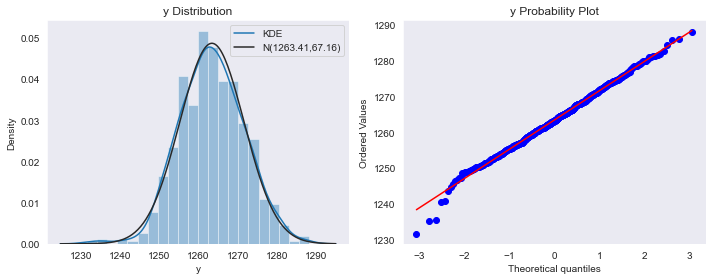

In [45]:
QQ_plot(df_final['y'], 'y')

In [ ]:
QQ_plot(df_final['y'], 'y')

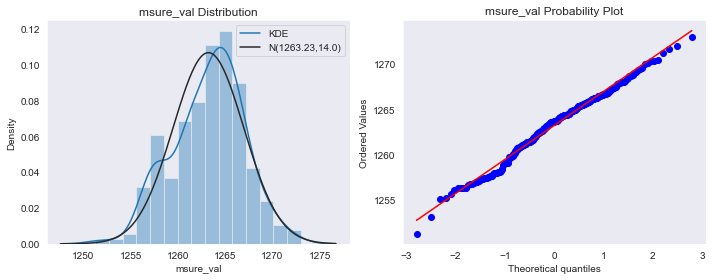

In [46]:
predict['msure_val'] = model_lgb.predict(df_predict_final[COLS])
QQ_plot(predict['msure_val'], 'msure_val')

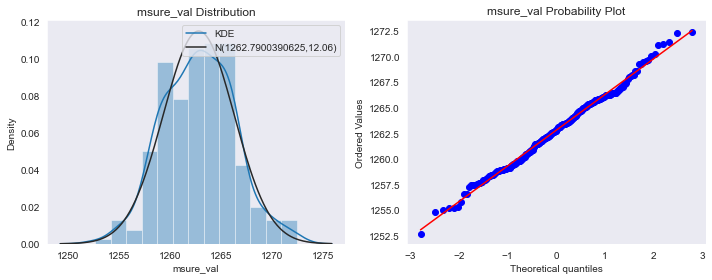

In [47]:
predict['msure_val'] = model_xgb.predict(df_predict_final_ohe[COLS_ohe])
QQ_plot(predict['msure_val'], 'msure_val')

#### 분산이 씹창이야

# EN

In [97]:
from sklearn.linear_model import ElasticNet
# from sklearn.preprocessing import StandardScaler  정규화 하지마.

In [109]:
# df_final_ohe.loc[:,df_final_ohe.dtypes==float]

,y,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para21,04_gas_para36,04_gas_para51,04_gas_para6,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para12,04_temp_para18,04_temp_para20,04_temp_para38,04_temp_para54,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para86,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para21,06_gas_para36,06_gas_para6,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para12,06_temp_para18,06_temp_para20,06_temp_para38,06_temp_para54,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para86,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para21,12_gas_para36,12_gas_para6,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para24,12_temp_para38,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para86,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_esc_para84,13_esc_para94,13_fr_para28,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para21,13_gas_para36,13_gas_para46,13_gas_para6,13_he_para22,13_he_para88,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para57,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para12,13_temp_para17,13_temp_para18,13_temp_para20,13_temp_para24,13_temp_para38,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para86,13_tmp_para31,17_esc_para84,17_esc_para94,17_fr_para28,17_fr_para35,17_fr_para61,17_fr_para69,17_gas_para21,17_gas_para36,17_gas_para6,17_he_para22,17_he_para88,17_hv_para3,17_hv_para45,17_hv_para47,17_hv_para56,17_position_para72,17_power_para14,17_power_para57,17_power_para76,17_power_para82,17_temp_para12,17_temp_para17,17_temp_para18,17_temp_para20,17_temp_para24,17_temp_para38,17_temp_para58,17_temp_para60,17_temp_para65,17_temp_para66,17_temp_para86,17_time_para16,17_time_para29,17_time_para30,17_time_para34,17_time_para37,17_time_para41,17_time_para42,17_time_para43,17_time_para44,17_time_para62,17_time_para64,17_time_para67,17_time_para7,17_time_para75,17_time_para77,17_time_para8,17_time_para81,17_time_para83,17_time_para89,17_time_para9,17_time_para90,17_tmp_para31,18_esc_para84,18_esc_para94,18_fr_para28,18_fr_para35,18_fr_para61,18_fr_para69,18_gas_para21,18_gas_para36,18_gas_para46,18_gas_para6,18_he_para22,18_he_para88,18_hv_para3,18_hv_para45,18_hv_para47,18_hv_para56,18_position_para72,18_power_para14,18_power_para57,18_power_para68,18_power_para76,18_power_para82,18_pressure_para91,18_temp_para12,18_temp_para17,18_temp_para18,18_temp_para20,18_temp_para24,18_temp_para38,18_temp_para58,18_temp_para60,

In [110]:
# sin_col = df_final_ohe.filter(regex='sin').columns.tolist()
# cos_col = df_final_ohe.filter(regex='cos').columns.tolist()
# numf = df_final_ohe.loc[:,df_final_ohe.dtypes==float].columns.tolist()
# numf.remove('y')
# numf = [col for col in numf if col not in sin_col]
# numf = [col for col in numf if col not in cos_col]
# numf

# scaler = StandardScaler()
# df_final_ohe.loc[:,numf] = scaler.fit_transform(df_final_ohe[numf])
# df_predict_final_ohe.loc[:,numf] = scaler.transform(df_predict_final_ohe[numf])

['04_esc_para84',
 '04_esc_para94',
 '04_fr_para28',
 '04_fr_para35',
 '04_fr_para61',
 '04_fr_para69',
 '04_gas_para21',
 '04_gas_para36',
 '04_gas_para51',
 '04_gas_para6',
 '04_he_para22',
 '04_he_para88',
 '04_hv_para3',
 '04_hv_para45',
 '04_hv_para47',
 '04_hv_para56',
 '04_position_para72',
 '04_power_para57',
 '04_power_para76',
 '04_pressure_para91',
 '04_temp_para12',
 '04_temp_para18',
 '04_temp_para20',
 '04_temp_para38',
 '04_temp_para54',
 '04_temp_para58',
 '04_temp_para60',
 '04_temp_para65',
 '04_temp_para66',
 '04_temp_para86',
 '04_time_para16',
 '04_time_para29',
 '04_time_para30',
 '04_time_para34',
 '04_time_para37',
 '04_time_para41',
 '04_time_para42',
 '04_time_para43',
 '04_time_para44',
 '04_time_para62',
 '04_time_para64',
 '04_time_para67',
 '04_time_para7',
 '04_time_para75',
 '04_time_para77',
 '04_time_para8',
 '04_time_para81',
 '04_time_para83',
 '04_time_para89',
 '04_time_para9',
 '04_time_para90',
 '04_tmp_para31',
 '06_epd_para4',
 '06_epd_para40',

In [113]:
def objective_en(trial):
    param = {
            'alpha':trial.suggest_float("alpha",1e-6,1.0),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'selection':trial.suggest_categorical('selection', ['cyclic','random']),
            'l1_ratio':trial.suggest_float("l1_ratio",1e-6,1.0)
    }
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = ElasticNet(**param, random_state=42)
    cv = KFold(11, shuffle=True, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmsle_val = np.mean(scores)

    return rmsle_val
    
sampler = TPESampler(seed=42)
study_en = optuna.create_study(
            study_name="en_parameter_opt",
            direction="minimize",
            sampler=sampler,
)
study_en.optimize(objective_en, n_trials=30)
print("Best Score:", study_en.best_value)
print("Best trial:", study_en.best_trial.params)
    
model_en = ElasticNet(**study_en.best_params, random_state=42)
model_en.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-26 23:39:30,350] A new study created in memory with name: en_parameter_opt
[I 2022-07-26 23:39:30,480] Trial 0 finished with value: 8.170578572671632 and parameters: {'alpha': 0.3745407443072436, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.8661762795987894}. Best is trial 0 with value: 8.170578572671632.
[I 2022-07-26 23:39:30,607] Trial 1 finished with value: 8.170578572671632 and parameters: {'alpha': 0.6011154106281971, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.18340532644892396}. Best is trial 0 with value: 8.170578572671632.


CV scores : [6.58314676 8.89682129 8.08485675 9.83722359 9.28967564 8.45285181
 7.85283592 8.77135935 7.24121711 7.11091481 7.75546125]
Mean score :  8.170578572671632
CV scores : [6.58314676 8.89682129 8.08485675 9.83722359 9.28967564 8.45285181
 7.85283592 8.77135935 7.24121711 7.11091481 7.75546125]
Mean score :  8.170578572671632


[I 2022-07-26 23:39:30,767] Trial 2 finished with value: 7.959400477314318 and parameters: {'alpha': 0.30424293871729474, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.36636247693184837}. Best is trial 2 with value: 7.959400477314318.
[I 2022-07-26 23:39:30,919] Trial 3 finished with value: 7.975465957126134 and parameters: {'alpha': 0.4560705281470517, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.17052495316316785}. Best is trial 2 with value: 7.959400477314318.


CV scores : [6.28325998 8.17633979 7.4594597  9.70447464 9.08348181 7.72237177
 7.96426428 8.78137317 7.51051815 7.43540651 7.43245546]
Mean score :  7.959400477314318
CV scores : [6.30990987 8.18133275 7.47841244 9.68979025 9.10188671 7.77000871
 7.98947879 8.73742073 7.58932921 7.47961274 7.40294332]
Mean score :  7.975465957126134


[I 2022-07-26 23:39:31,318] Trial 4 finished with value: 170.3813662378362 and parameters: {'alpha': 0.06505252793368653, 'fit_intercept': False, 'normalize': True, 'selection': 'random', 'l1_ratio': 0.44015305358710755}. Best is trial 2 with value: 7.959400477314318.
[I 2022-07-26 23:39:31,458] Trial 5 finished with value: 8.169498698322856 and parameters: {'alpha': 0.12203911280654398, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.5200685011097896}. Best is trial 2 with value: 7.959400477314318.


CV scores : [ 80.60550652  74.90447559 181.70196421  64.71043786  69.63555546
  76.03643167 238.76563262 179.55651886 165.93875241 503.44952621
 238.89022721]
Mean score :  170.3813662378362
CV scores : [6.58120434 8.89655358 8.08279863 9.83652851 9.28927172 8.45164306
 7.85157061 8.77046548 7.23943297 7.10955435 7.75546242]
Mean score :  8.169498698322856


[I 2022-07-26 23:39:32,944] Trial 6 finished with value: 148.40170197697168 and parameters: {'alpha': 0.5467107326330003, 'fit_intercept': False, 'normalize': False, 'selection': 'cyclic', 'l1_ratio': 0.9218743131488818}. Best is trial 2 with value: 7.959400477314318.


CV scores : [ 80.66815075  76.70580763 154.14995337  68.28070557  74.87139503
  79.24981817 196.31708242 153.94806233 139.48668311 414.1684407
 194.57262268]
Mean score :  148.40170197697168


[I 2022-07-26 23:39:33,183] Trial 7 finished with value: 8.114758226551318 and parameters: {'alpha': 0.08849341355941745, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.35675396994026254}. Best is trial 2 with value: 7.959400477314318.
[I 2022-07-26 23:39:33,319] Trial 8 finished with value: 8.169262030456382 and parameters: {'alpha': 0.280935228752871, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 2 with value: 7.959400477314318.


CV scores : [6.11008221 7.97724682 7.72140719 9.48132117 8.9967528  7.55452317
 7.89417228 8.60138952 7.62240884 9.57960794 7.72342856]
Mean score :  8.114758226551318
CV scores : [6.58085394 8.89574635 8.08319911 9.83714119 9.28902685 8.45102517
 7.85145905 8.76988842 7.24064183 7.10877691 7.75412353]
Mean score :  8.169262030456382


[I 2022-07-26 23:39:34,804] Trial 9 finished with value: 8.456485586179966 and parameters: {'alpha': 0.0055231116014852755, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.11586994365607019}. Best is trial 2 with value: 7.959400477314318.
[I 2022-07-26 23:39:34,985] Trial 10 finished with value: 380.37086082047716 and parameters: {'alpha': 0.8660407925851672, 'fit_intercept': False, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.6518668989116276}. Best is trial 2 with value: 7.959400477314318.


CV scores : [ 6.24600035  7.48045977  7.95794633  8.63777761  8.63815551  7.6627966
  7.86455352  7.96710442  7.70201741 14.39048757  8.47404236]
Mean score :  8.456485586179966
CV scores : [314.92862468 310.51824623 377.38328557 292.61785262 308.20560067
 318.85686217 424.32129522 403.67916306 338.97114264 681.66346137
 412.93393481]
Mean score :  380.37086082047716


[I 2022-07-26 23:39:35,153] Trial 11 finished with value: 8.005364136364966 and parameters: {'alpha': 0.7331986112061764, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.006691663608159704}. Best is trial 2 with value: 7.959400477314318.
[I 2022-07-26 23:39:35,320] Trial 12 finished with value: 7.9553020060237705 and parameters: {'alpha': 0.4039476089621281, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.2987420519179498}. Best is trial 12 with value: 7.9553020060237705.


CV scores : [6.35116241 8.17404426 7.60914614 9.65797185 9.08818798 7.77067826
 8.00572245 8.69688209 7.76448966 7.58068642 7.36003398]
Mean score :  8.005364136364966
CV scores : [6.32988019 8.20070531 7.46755157 9.70134582 9.0942537  7.76529486
 7.97063569 8.77208661 7.50712718 7.30383409 7.39560706]
Mean score :  7.9553020060237705


[I 2022-07-26 23:39:35,495] Trial 13 finished with value: 7.968887607271879 and parameters: {'alpha': 0.27392851841491217, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.33993895894576703}. Best is trial 12 with value: 7.9553020060237705.


CV scores : [6.24771166 8.15539882 7.46693585 9.70480938 9.08538039 7.70620267
 7.96892702 8.76466541 7.54237561 7.55221801 7.46313885]
Mean score :  7.968887607271879


[I 2022-07-26 23:39:35,726] Trial 14 finished with value: 238.30680788464267 and parameters: {'alpha': 0.278880928182903, 'fit_intercept': False, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.6276433176130044}. Best is trial 12 with value: 7.9553020060237705.
[I 2022-07-26 23:39:35,892] Trial 15 finished with value: 7.952812878821286 and parameters: {'alpha': 0.41922917406362525, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.30791456708914167}. Best is trial 15 with value: 7.952812878821286.


CV scores : [164.11097705 157.70031181 237.2292663  139.47879929 152.16954816
 162.34905622 290.76498042 243.01136638 206.87157953 583.28272184
 284.40627975]
Mean score :  238.30680788464267
CV scores : [6.34192949 8.20670157 7.46689735 9.70230202 9.09434666 7.77289769
 7.97136842 8.77175014 7.49195515 7.27525534 7.38553785]
Mean score :  7.952812878821286


[I 2022-07-26 23:39:36,042] Trial 16 finished with value: 7.98122506933414 and parameters: {'alpha': 0.999362439279113, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.2683021472489503}. Best is trial 15 with value: 7.952812878821286.
[I 2022-07-26 23:39:36,193] Trial 17 finished with value: 7.971107581460222 and parameters: {'alpha': 0.6446740405944003, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.5229627900235617}. Best is trial 15 with value: 7.952812878821286.


CV scores : [6.48927138 8.34817999 7.61940541 9.69127179 9.14104443 8.00396644
 7.9115868  8.77252617 7.39790264 7.0139587  7.40436202]
Mean score :  7.98122506933414
CV scores : [6.46965206 8.34894879 7.59579472 9.6633857  9.13452298 7.99266266
 7.90329864 8.8090703  7.32619764 7.01904736 7.41960253]
Mean score :  7.971107581460222


[I 2022-07-26 23:39:36,408] Trial 18 finished with value: 248.83531211243636 and parameters: {'alpha': 0.4606402633400558, 'fit_intercept': False, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.7411534500267567}. Best is trial 15 with value: 7.952812878821286.
[I 2022-07-26 23:39:36,580] Trial 19 finished with value: 7.993904093432764 and parameters: {'alpha': 0.7306426636371708, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.028246996530449486}. Best is trial 15 with value: 7.952812878821286.


CV scores : [178.06368867 172.13655957 246.79447168 153.5826973  166.87145339
 177.20085492 298.15820159 254.77116273 215.45597538 583.53109242
 290.62227557]
Mean score :  248.83531211243636
CV scores : [6.34661745 8.17666677 7.56872586 9.6613866  9.08799404 7.78082016
 8.00917985 8.69851423 7.72311066 7.52034022 7.35958919]
Mean score :  7.993904093432764


[I 2022-07-26 23:39:36,769] Trial 20 finished with value: 8.056438239369422 and parameters: {'alpha': 0.16679878324086622, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.27859950318996474}. Best is trial 15 with value: 7.952812878821286.
[I 2022-07-26 23:39:36,935] Trial 21 finished with value: 7.9492805908259445 and parameters: {'alpha': 0.38061678382952696, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.4192973553701799}. Best is trial 21 with value: 7.9492805908259445.


CV scores : [6.17418534 8.09116235 7.56562863 9.64617944 9.07792197 7.64822677
 7.95430716 8.69042415 7.63751704 8.54181162 7.59345615]
Mean score :  8.056438239369422
CV scores : [6.35727356 8.22016227 7.45079048 9.70284005 9.09389961 7.78542038
 7.97394983 8.78595335 7.43250052 7.2696746  7.36962185]
Mean score :  7.9492805908259445


[I 2022-07-26 23:39:37,103] Trial 22 finished with value: 7.949551131112168 and parameters: {'alpha': 0.37098865666316116, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.4457722967069806}. Best is trial 21 with value: 7.9492805908259445.
[I 2022-07-26 23:39:37,264] Trial 23 finished with value: 7.948194732896795 and parameters: {'alpha': 0.3576915664581015, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.4517931683598108}. Best is trial 23 with value: 7.948194732896795.


CV scores : [6.3604263  8.22282152 7.44867216 9.70289688 9.09583154 7.78764839
 7.9766272  8.79079774 7.41965252 7.27194463 7.36774357]
Mean score :  7.949551131112168
CV scores : [6.35218369 8.21707661 7.44351172 9.70353423 9.09184023 7.77773754
 7.97405039 8.79112247 7.42401881 7.28484079 7.37022558]
Mean score :  7.948194732896795


[I 2022-07-26 23:39:37,424] Trial 24 finished with value: 7.981768284966083 and parameters: {'alpha': 0.548153285638395, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.4487810844590085}. Best is trial 23 with value: 7.948194732896795.
[I 2022-07-26 23:39:37,618] Trial 25 finished with value: 7.941665380387144 and parameters: {'alpha': 0.19635995590507613, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.6042171571237571}. Best is trial 25 with value: 7.941665380387144.


CV scores : [6.4774276  8.31097352 7.54112715 9.71029968 9.12634949 7.92028766
 7.98285971 8.8318017  7.39558346 7.10074032 7.40200083]
Mean score :  7.981768284966083
CV scores : [6.21822812 8.1303542  7.45006696 9.70378845 9.02502815 7.64070721
 7.92397234 8.78132181 7.46641463 7.54206217 7.47637515]
Mean score :  7.941665380387144


[I 2022-07-26 23:39:39,093] Trial 26 finished with value: 226.47097291941108 and parameters: {'alpha': 0.22836698205584716, 'fit_intercept': False, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.6024793949364915}. Best is trial 25 with value: 7.941665380387144.


CV scores : [150.37809338 143.93984116 226.69678127 126.53317778 138.24329985
 147.99774886 280.75828609 230.55170658 197.95690001 572.9209923
 275.20387483]
Mean score :  226.47097291941108
CV scores : [6.18265892 8.09938851 7.43916487 9.68947937 8.99004984 7.59451276
 7.89514743 8.77434402 7.44020247 7.52381638 7.46976618]


[I 2022-07-26 23:39:39,296] Trial 27 finished with value: 7.91804824920803 and parameters: {'alpha': 0.17058613572594483, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.748717613223816}. Best is trial 27 with value: 7.91804824920803.
[I 2022-07-26 23:39:39,498] Trial 28 finished with value: 7.913205135652493 and parameters: {'alpha': 0.19968645105458246, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.7744333794069443}. Best is trial 28 with value: 7.913205135652493.


Mean score :  7.91804824920803
CV scores : [6.23248579 8.14049074 7.40301793 9.69315748 9.02045948 7.65090643
 7.92586175 8.80929035 7.39785746 7.38342525 7.38830383]
Mean score :  7.913205135652493


[I 2022-07-26 23:39:39,638] Trial 29 finished with value: 8.170578572671632 and parameters: {'alpha': 0.19068680983897512, 'fit_intercept': True, 'normalize': True, 'selection': 'cyclic', 'l1_ratio': 0.7752285039393251}. Best is trial 28 with value: 7.913205135652493.


CV scores : [6.58314676 8.89682129 8.08485675 9.83722359 9.28967564 8.45285181
 7.85283592 8.77135935 7.24121711 7.11091481 7.75546125]
Mean score :  8.170578572671632
Best Score: 7.913205135652493
Best trial: {'alpha': 0.19968645105458246, 'fit_intercept': True, 'normalize': False, 'selection': 'random', 'l1_ratio': 0.7744333794069443}
model training is completed


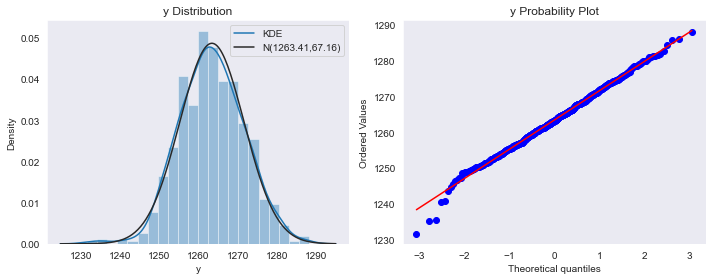

In [53]:
QQ_plot(df_final['y'], 'y')

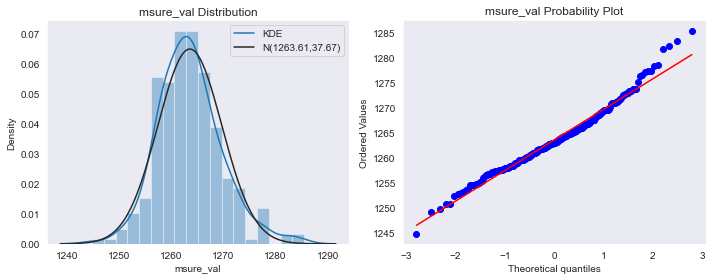

In [55]:
predict['msure_val'] = model_en.predict(df_predict_final_ohe[COLS_ohe])
QQ_plot(predict['msure_val'], 'msure_val')

In [56]:
model_en.predict(df_predict_final_ohe[COLS_ohe])

array([1260.63391136, 1256.64788319, 1259.00277786, 1259.6425014 ,
       1265.41918803, 1260.91828786, 1263.66684659, 1262.37682213,
       1261.20997505, 1257.41757036, 1258.51556781, 1262.70884855,
       1264.72670836, 1257.38989341, 1252.41484124, 1256.25811141,
       1252.86143329, 1249.24920445, 1254.55681561, 1264.66510931,
       1264.43388567, 1254.96479004, 1253.62285451, 1253.88238902,
       1254.86576659, 1253.02812957, 1259.54864546, 1258.35505929,
       1266.15192657, 1265.84596798, 1261.88334659, 1264.14107817,
       1257.58558266, 1261.68933345, 1263.99862092, 1265.49970708,
       1265.29226262, 1264.87012715, 1272.72718088, 1273.39189915,
       1259.73449643, 1264.23421259, 1266.83819119, 1265.28595396,
       1255.40887721, 1259.06273029, 1260.2255689 , 1260.20268459,
       1262.48116429, 1264.73400314, 1266.89338166, 1258.31201208,
       1257.76958746, 1249.80639419, 1257.54075879, 1269.61836787,
       1267.58252972, 1269.72068023, 1265.21292186, 1262.32900

# BR

In [58]:
from sklearn.linear_model import BayesianRidge

In [61]:
def objective_BR(trial):
    param_br = {
            'n_iter':trial.suggest_int("n_iter",500,2000),
            'alpha_2':trial.suggest_float("alpha_2",1e-6, 20.0),
            'lambda_2' :trial.suggest_float('lambda_2', 1e-6, 20.0),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'tol':trial.suggest_float("tol",1e-6,1e-2)
    }
    
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = BayesianRidge(**param_br)
    cv = KFold(11, shuffle=True, random_state=42)

    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmsle_val = np.mean(scores)

    return rmsle_val
    
sampler = TPESampler(seed=42)
study_br = optuna.create_study(
            study_name="BayesianRidge_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )

study_br.optimize(objective_BR, n_trials=30)
print("Best Score:", study_br.best_value)
print("Best trial:", study_br.best_trial.params)
    
model_br = BayesianRidge(**study_br.best_params)
model_br.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-26 22:49:25,446] A new study created in memory with name: BayesianRidge_parameter_opt
[I 2022-07-26 22:49:27,447] Trial 0 finished with value: 14.727712145263075 and parameters: {'n_iter': 437, 'alpha_2': 19.014286177484017, 'lambda_2': 14.639879104234158, 'fit_intercept': True, 'normalize': True, 'tol': 0.008661895281603577}. Best is trial 0 with value: 14.727712145263075.


CV scores : [ 7.94113127  9.24035092  7.42626239  8.517093    8.66715431  7.57660971
  7.64963633  7.40225655  8.73094531 81.36339985  7.48999394]
Mean score :  14.727712145263075


[I 2022-07-26 22:49:29,713] Trial 1 finished with value: 13.821496761872858 and parameters: {'n_iter': 641, 'alpha_2': 14.16145184784833, 'lambda_2': 0.4116908653315546, 'fit_intercept': True, 'normalize': True, 'tol': 0.001834861694024485}. Best is trial 1 with value: 13.821496761872858.


CV scores : [ 7.94204544  9.24547547  7.44646269  8.52274418  8.34028322  7.60262052
  7.66921286  7.42678626  8.7789443  71.56887471  7.49301472]
Mean score :  13.821496761872858


[I 2022-07-26 22:49:31,286] Trial 2 finished with value: 7.388565965479264 and parameters: {'n_iter': 374, 'alpha_2': 10.495129107888324, 'lambda_2': 8.638900940897296, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624}. Best is trial 2 with value: 7.388565965479264.


CV scores : [8.13580384 8.41317484 6.15699393 7.68388348 6.90452193 6.32421404
 8.4212353  7.32050721 7.28874339 7.24783342 7.37731426]
Mean score :  7.388565965479264


[I 2022-07-26 22:49:32,887] Trial 3 finished with value: 7.4193202830618 and parameters: {'n_iter': 510, 'alpha_2': 15.703519442684309, 'lambda_2': 3.9934764434934125, 'fit_intercept': False, 'normalize': False, 'tol': 0.001706070712749228}. Best is trial 2 with value: 7.388565965479264.


CV scores : [8.09092036 8.4661553  6.15949543 7.70232631 6.98268604 6.37154433
 8.41692786 7.36951745 7.438159   7.2213688  7.39342225]
Mean score :  7.4193202830618


[I 2022-07-26 22:49:34,420] Trial 4 finished with value: 7.3539662002949235 and parameters: {'n_iter': 158, 'alpha_2': 18.977710796181128, 'lambda_2': 19.312640695859155, 'fit_intercept': True, 'normalize': False, 'tol': 0.004402084784902274}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [8.1580715  8.34805925 6.14420177 7.66625227 6.82508712 6.30538377
 8.39463971 7.22941396 7.14429974 7.30694417 7.37127493]
Mean score :  7.3539662002949235


[I 2022-07-26 22:49:36,693] Trial 5 finished with value: 13.852187502283213 and parameters: {'n_iter': 209, 'alpha_2': 9.903538707048492, 'lambda_2': 0.6877713879158468, 'fit_intercept': True, 'normalize': True, 'tol': 0.005201160143756931}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [ 7.94200825  9.24536372  7.44579308  8.52252832  8.34981049  7.60165668
  7.66861578  7.42599491  8.77751652 71.90185458  7.49292019]
Mean score :  13.852187502283213


[I 2022-07-26 22:49:38,207] Trial 6 finished with value: 7.356541530667193 and parameters: {'n_iter': 592, 'alpha_2': 3.697089925656085, 'lambda_2': 19.391692585706544, 'fit_intercept': False, 'normalize': True, 'tol': 0.009218820475996146}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [8.15914061 8.35159977 6.14486956 7.6558419  6.84092202 6.28602355
 8.40122534 7.24693351 7.1558143  7.31898835 7.36059793]
Mean score :  7.356541530667193


[I 2022-07-26 22:49:39,870] Trial 7 finished with value: 7.4986962161104564 and parameters: {'n_iter': 179, 'alpha_2': 3.9196580524000413, 'lambda_2': 0.9045467329834724, 'fit_intercept': False, 'normalize': False, 'tol': 0.0035681765136091996}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [8.03288918 8.60195578 6.17735048 7.76784868 7.13674455 6.5254224
 8.35914529 7.40106187 7.7827661  7.29154227 7.40893177]
Mean score :  7.4986962161104564


[I 2022-07-26 22:49:42,063] Trial 8 finished with value: 14.023256094455116 and parameters: {'n_iter': 353, 'alpha_2': 10.853922120468885, 'lambda_2': 2.818485358571028, 'fit_intercept': True, 'normalize': True, 'tol': 0.00198795809966019}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [ 7.941801    9.24462815  7.44178931  8.52131593  8.40464019  7.59595103
  7.66494676  7.4212161   8.76847484 73.75869644  7.49235729]
Mean score :  14.023256094455116


[I 2022-07-26 22:49:43,605] Trial 9 finished with value: 7.369607434768366 and parameters: {'n_iter': 104, 'alpha_2': 16.309228753635256, 'lambda_2': 14.137147170094996, 'fit_intercept': False, 'normalize': False, 'tol': 0.001159574726191772}. Best is trial 4 with value: 7.3539662002949235.


CV scores : [8.15511342 8.37791986 6.15126508 7.66822124 6.86253065 6.30058729
 8.41249027 7.2789258  7.20524119 7.28655846 7.3668285 ]
Mean score :  7.369607434768366


[I 2022-07-26 22:49:45,121] Trial 10 finished with value: 7.353658030325703 and parameters: {'n_iter': 951, 'alpha_2': 0.11994465311915903, 'lambda_2': 19.390742246220213, 'fit_intercept': True, 'normalize': False, 'tol': 0.006902780488617885}. Best is trial 10 with value: 7.353658030325703.


CV scores : [8.15806119 8.3474086  6.1440177  7.6659083  6.82465398 6.30505173
 8.39431373 7.2286444  7.14324135 7.30775014 7.37118723]
Mean score :  7.353658030325703


[I 2022-07-26 22:49:46,632] Trial 11 finished with value: 7.353632151903114 and parameters: {'n_iter': 980, 'alpha_2': 0.8298543335060141, 'lambda_2': 19.404428972474502, 'fit_intercept': True, 'normalize': False, 'tol': 0.006971861827502606}. Best is trial 11 with value: 7.353632151903114.


CV scores : [8.15806015 8.34735548 6.14400235 7.66588039 6.82461817 6.30502386
 8.39428786 7.22857977 7.14315202 7.30781353 7.37118009]
Mean score :  7.353632151903114


[I 2022-07-26 22:49:48,126] Trial 12 finished with value: 7.361751621764369 and parameters: {'n_iter': 977, 'alpha_2': 0.6509985805674281, 'lambda_2': 16.039196319251943, 'fit_intercept': True, 'normalize': False, 'tol': 0.006985872934878635}. Best is trial 11 with value: 7.353632151903114.


CV scores : [8.15680742 8.36385786 6.14861612 7.67454959 6.83714838 6.31374703
 8.40193558 7.24860385 7.17249691 7.28782366 7.37368145]
Mean score :  7.361751621764369


[I 2022-07-26 22:49:49,689] Trial 13 finished with value: 7.382942798480323 and parameters: {'n_iter': 969, 'alpha_2': 0.13132368470390454, 'lambda_2': 9.423016930278663, 'fit_intercept': True, 'normalize': False, 'tol': 0.006768503762898054}. Best is trial 11 with value: 7.353632151903114.


CV scores : [8.13949411 8.40379533 6.15788875 7.69487803 6.88084053 6.33779654
 8.4148699  7.29704357 7.26105074 7.24248171 7.38223155]
Mean score :  7.382942798480323


[I 2022-07-26 22:49:51,174] Trial 14 finished with value: 7.359501517863754 and parameters: {'n_iter': 795, 'alpha_2': 4.616970743100363, 'lambda_2': 16.93507430104776, 'fit_intercept': True, 'normalize': False, 'tol': 0.007399610900173708}. Best is trial 11 with value: 7.353632151903114.


CV scores : [8.15747271 8.35935243 6.14738457 7.67218899 6.83342638 6.31132727
 8.39994917 7.24311144 7.16408739 7.29327606 7.3729403 ]
Mean score :  7.359501517863754


[I 2022-07-26 22:49:52,733] Trial 15 finished with value: 7.37228472469672 and parameters: {'n_iter': 820, 'alpha_2': 6.817522901920603, 'lambda_2': 12.383357928913977, 'fit_intercept': True, 'normalize': False, 'tol': 0.006282652790464055}. Best is trial 11 with value: 7.353632151903114.


CV scores : [8.15053636 8.3842735  6.15378568 7.68513584 6.85706576 6.32530211
 8.40974746 7.27354055 7.21452533 7.26359979 7.3776196 ]
Mean score :  7.37228472469672


[I 2022-07-26 22:49:54,283] Trial 16 finished with value: 7.352546479513384 and parameters: {'n_iter': 824, 'alpha_2': 2.0771218635561906, 'lambda_2': 19.89420992293578, 'fit_intercept': True, 'normalize': False, 'tol': 0.0082087417512793}. Best is trial 16 with value: 7.352546479513384.


CV scores : [8.1579872  8.34510124 6.14335382 7.66469439 6.82313376 6.30385356
 8.39317232 7.22586306 7.1394368  7.31053217 7.37088295]
Mean score :  7.352546479513384


[I 2022-07-26 22:49:55,862] Trial 17 finished with value: 7.3979738769791945 and parameters: {'n_iter': 813, 'alpha_2': 6.779287467854153, 'lambda_2': 6.417004251546164, 'fit_intercept': True, 'normalize': False, 'tol': 0.009692729250635131}. Best is trial 16 with value: 7.352546479513384.


CV scores : [8.11858197 8.42975409 6.16188886 7.70681589 6.91822592 6.35757764
 8.41713429 7.32613652 7.33137945 7.22100674 7.38921127]
Mean score :  7.3979738769791945


[I 2022-07-26 22:49:57,422] Trial 18 finished with value: 7.3733996652474785 and parameters: {'n_iter': 711, 'alpha_2': 2.285449089156579, 'lambda_2': 12.030855296111215, 'fit_intercept': True, 'normalize': False, 'tol': 0.008379417154311132}. Best is trial 16 with value: 7.352546479513384.


CV scores : [8.1495861  8.38636514 6.15426943 7.6862016  6.85939882 6.32656243
 8.41041766 7.2760914  7.21921847 7.26120929 7.37807598]
Mean score :  7.3733996652474785


[I 2022-07-26 22:49:58,933] Trial 19 finished with value: 7.3583675088281515 and parameters: {'n_iter': 887, 'alpha_2': 6.272032864493445, 'lambda_2': 17.39998596957593, 'fit_intercept': True, 'normalize': False, 'tol': 0.0055358212149472195}. Best is trial 16 with value: 7.352546479513384.


CV scores : [8.1577157  8.3570631  6.14674958 7.67098535 6.8316211  6.31011086
 8.39890779 7.24032691 7.15992828 7.29605373 7.3725802 ]
Mean score :  7.3583675088281515


[I 2022-07-26 22:50:00,470] Trial 20 finished with value: 7.372190590785834 and parameters: {'n_iter': 716, 'alpha_2': 1.9389192017430539, 'lambda_2': 12.402978535542243, 'fit_intercept': True, 'normalize': False, 'tol': 0.007794652974513944}. Best is trial 16 with value: 7.352546479513384.


CV scores : [8.15061643 8.38409345 6.15374417 7.68504284 6.85687083 6.32519535
 8.40968749 7.27332456 7.21413128 7.26380964 7.37758047]
Mean score :  7.372190590785834


[I 2022-07-26 22:50:02,024] Trial 21 finished with value: 7.352344529008019 and parameters: {'n_iter': 911, 'alpha_2': 1.7015494848326687, 'lambda_2': 19.984031129410614, 'fit_intercept': True, 'normalize': False, 'tol': 0.006035707919999107}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15796746 8.34467991 6.14323286 7.66447358 6.82286234 6.30363629
 8.3929628  7.22535659 7.13875092 7.31103829 7.37082877]
Mean score :  7.352344529008019


[I 2022-07-26 22:50:03,570] Trial 22 finished with value: 7.356539220011169 and parameters: {'n_iter': 887, 'alpha_2': 2.7559120242562365, 'lambda_2': 18.15117786087796, 'fit_intercept': True, 'normalize': False, 'tol': 0.005915585192286259}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.1579771  8.35333908 6.14570603 7.66902871 6.82881459 6.30814834
 8.39717323 7.23581141 7.15334259 7.30057075 7.37201959]
Mean score :  7.356539220011169


[I 2022-07-26 22:50:05,093] Trial 23 finished with value: 7.3623017959307075 and parameters: {'n_iter': 899, 'alpha_2': 5.670488872516266, 'lambda_2': 15.840980522852181, 'fit_intercept': True, 'normalize': False, 'tol': 0.008165536144837358}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15660742 8.36495566 6.14891126 7.67512437 6.83808892 6.31433991
 8.40240807 7.24993926 7.17458215 7.28649365 7.37386906]
Mean score :  7.3623017959307075


[I 2022-07-26 22:50:06,648] Trial 24 finished with value: 7.352475532731236 and parameters: {'n_iter': 742, 'alpha_2': 8.652380224883236, 'lambda_2': 19.947078937921717, 'fit_intercept': True, 'normalize': False, 'tol': 0.004760018271327613}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15798083 8.34495753 6.14331187 7.66462001 6.8230393  6.3037775
 8.39310317 7.22568487 7.13919342 7.31069798 7.37086438]
Mean score :  7.352475532731236


[I 2022-07-26 22:50:08,178] Trial 25 finished with value: 7.357028665967615 and parameters: {'n_iter': 726, 'alpha_2': 8.932850724131265, 'lambda_2': 17.962678076604295, 'fit_intercept': True, 'normalize': False, 'tol': 0.004410094946889911}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15792261 8.35434366 6.14598816 7.66955644 6.8295548  6.30867411
 8.39764771 7.23702414 7.15508864 7.29934718 7.37216788]
Mean score :  7.357028665967615


[I 2022-07-26 22:50:09,729] Trial 26 finished with value: 7.36860537718328 and parameters: {'n_iter': 776, 'alpha_2': 13.379609097995278, 'lambda_2': 14.473926679999463, 'fit_intercept': False, 'normalize': True, 'tol': 0.0030680453984632903}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15570835 8.375825   6.15081301 7.6673141  6.86073197 6.29963661
 8.41161879 7.27656514 7.20139223 7.28870401 7.36634994]
Mean score :  7.36860537718328


[I 2022-07-26 22:50:11,291] Trial 27 finished with value: 7.3526965651417155 and parameters: {'n_iter': 653, 'alpha_2': 8.599491748352552, 'lambda_2': 19.84708519720215, 'fit_intercept': True, 'normalize': False, 'tol': 0.004698678527918429}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15800096 8.34541767 6.14344449 7.66486208 6.82333733 6.30401599
 8.39333233 7.22623875 7.13994515 7.31014341 7.37092406]
Mean score :  7.3526965651417155


[I 2022-07-26 22:50:12,787] Trial 28 finished with value: 7.360207322729764 and parameters: {'n_iter': 871, 'alpha_2': 7.899347486941315, 'lambda_2': 16.662050706518286, 'fit_intercept': True, 'normalize': False, 'tol': 0.006160612054108341}. Best is trial 21 with value: 7.352344529008019.


CV scores : [8.15728961 8.36077433 6.14777548 7.67293396 6.83457419 6.3120862
 8.40058612 7.24484009 7.16670085 7.29155031 7.37316943]
Mean score :  7.360207322729764


[I 2022-07-26 22:50:14,782] Trial 29 finished with value: 14.767050426632458 and parameters: {'n_iter': 519, 'alpha_2': 12.425808452379982, 'lambda_2': 15.318743501294046, 'fit_intercept': True, 'normalize': True, 'tol': 0.008958496269515968}. Best is trial 21 with value: 7.352344529008019.


CV scores : [ 7.94110347  9.24005492  7.425456    8.51689146  8.68430871  7.57571845
  7.64880059  7.40125074  8.72894156 81.78516795  7.48986084]
Mean score :  14.767050426632458
Best Score: 7.352344529008019
Best trial: {'n_iter': 911, 'alpha_2': 1.7015494848326687, 'lambda_2': 19.984031129410614, 'fit_intercept': True, 'normalize': False, 'tol': 0.006035707919999107}
model training is completed


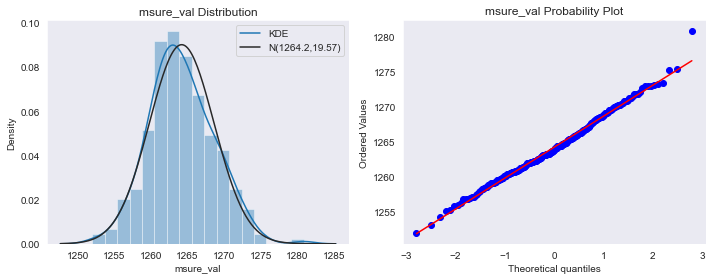

In [62]:
predict['msure_val'] = model_br.predict(df_predict_final_ohe[COLS_ohe])
QQ_plot(predict['msure_val'], 'msure_val')

# RF

In [64]:
def objective_RF(trial):
    param = {
#             "device_type": trial.suggest_categorical("device_type", ['gpu']),
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=10),
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30)
    }
        
    X = df_final_ohe[COLS_ohe]
    y = df_final_ohe['y']

    model = RandomForestRegressor(**param, random_state=42)  
    cv = KFold(5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
    scores = np.sqrt(-scores)
    print(f'CV scores : {scores}')
    print('Mean score : ', np.mean(scores))
    rmse_val = np.mean(scores)
     
    return rmse_val
    
sampler = TPESampler(seed=42)
study_rf = optuna.create_study(
            study_name="rf_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )

study_rf.optimize(objective_RF, n_trials=5)
print("Best Score:", study_rf.best_value)
print("Best trial:", study_rf.best_trial.params)
    
model_rf = RandomForestRegressor(**study_rf.best_params, random_state=42)
model_rf.fit(df_final_ohe[COLS_ohe], df_final_ohe['y'])
print('model training is completed')

[I 2022-07-26 23:04:09,532] A new study created in memory with name: rf_parameter_opt
[I 2022-07-26 23:05:13,909] Trial 0 finished with value: 7.493829466521855 and parameters: {'n_estimators': 810, 'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 18}. Best is trial 0 with value: 7.493829466521855.


CV scores : [7.80733683 7.72221922 6.65878716 8.19600035 7.08480377]
Mean score :  7.493829466521855


[I 2022-07-26 23:05:28,896] Trial 1 finished with value: 7.757082709520984 and parameters: {'n_estimators': 390, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 7.493829466521855.


CV scores : [8.05488442 8.10516609 7.01780673 8.33435604 7.27320026]
Mean score :  7.757082709520984


[I 2022-07-26 23:06:46,675] Trial 2 finished with value: 7.622551527800672 and parameters: {'n_estimators': 1240, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 7.493829466521855.


CV scores : [7.98140582 7.92440955 6.79552615 8.27083371 7.14058241]
Mean score :  7.622551527800672


[I 2022-07-26 23:08:19,099] Trial 3 finished with value: 7.588788767949145 and parameters: {'n_estimators': 1680, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 7.493829466521855.


CV scores : [7.85737106 7.75219827 6.8893551  8.23762011 7.2073993 ]
Mean score :  7.588788767949145


[I 2022-07-26 23:09:21,347] Trial 4 finished with value: 7.415635285874968 and parameters: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}. Best is trial 4 with value: 7.415635285874968.


CV scores : [7.67967348 7.565792   6.58755847 8.17366272 7.07148976]
Mean score :  7.415635285874968
Best Score: 7.415635285874968
Best trial: {'n_estimators': 680, 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 9}
model training is completed


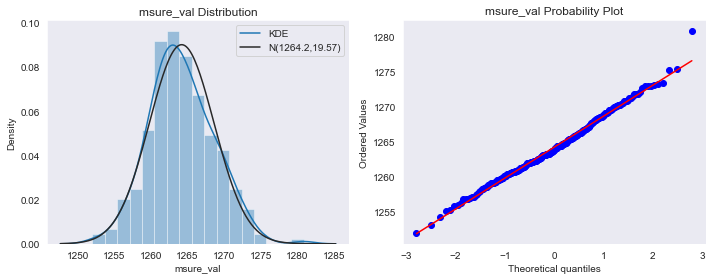

In [84]:
predict['msure_val'] = model_br.predict(df_predict_final_ohe[COLS_ohe])
QQ_plot(predict['msure_val'], 'msure_val')

In [66]:
with open('model_lgb.p', 'rb') as f:
    model_lgb = pickle.load(f)

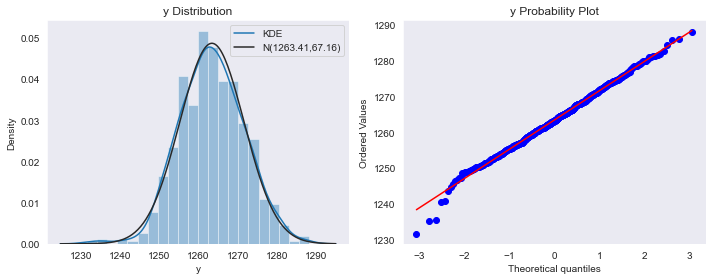

In [86]:
QQ_plot(df_final['y'], 'y')

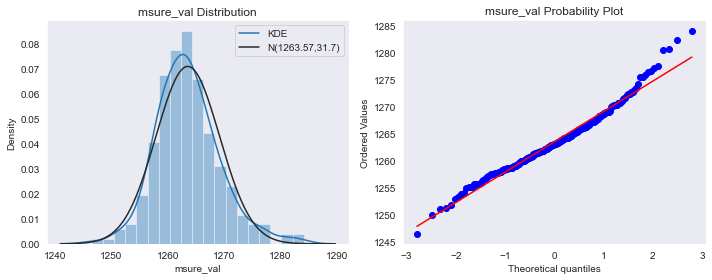

In [93]:
predict['msure_val'] = model_lgb.predict(df_predict_final[COLS])*0.1+model_en.predict(df_predict_final_ohe[COLS_ohe])*0.9
QQ_plot(predict['msure_val'], 'msure_val')

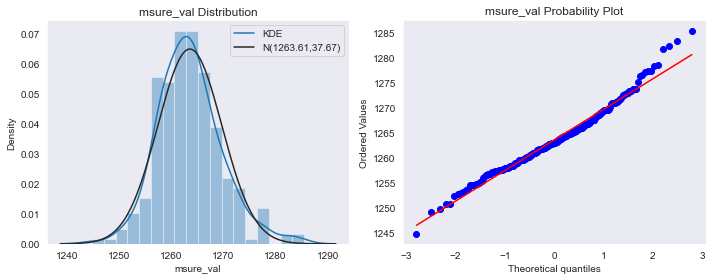

In [94]:
predict['msure_val'] = model_en.predict(df_predict_final_ohe[COLS_ohe])
QQ_plot(predict['msure_val'], 'msure_val')

In [95]:
predict['msure_val'] = model_en.predict(df_predict_final_ohe[COLS_ohe])
df_submission = predict[['key_val','msure_val']]
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_37.csv')

In [96]:
df_submission.head(10)

,msure_val
key_val,
LOT380_17,1260.633911
LOT122_18,1256.647883
LOT313_18,1259.002778
LOT459_12,1259.642501
LOT459_18,1265.419188
LOT227_18,1260.918288
LOT51_18,1263.666847
LOT213_10,1262.376822
LOT380_15,1261.209975


In [78]:
model_en.predict(df_predict_final_ohe[COLS_ohe])

array([1260.63391136, 1256.64788319, 1259.00277786, 1259.6425014 ,
       1265.41918803, 1260.91828786, 1263.66684659, 1262.37682213,
       1261.20997505, 1257.41757036, 1258.51556781, 1262.70884855,
       1264.72670836, 1257.38989341, 1252.41484124, 1256.25811141,
       1252.86143329, 1249.24920445, 1254.55681561, 1264.66510931,
       1264.43388567, 1254.96479004, 1253.62285451, 1253.88238902,
       1254.86576659, 1253.02812957, 1259.54864546, 1258.35505929,
       1266.15192657, 1265.84596798, 1261.88334659, 1264.14107817,
       1257.58558266, 1261.68933345, 1263.99862092, 1265.49970708,
       1265.29226262, 1264.87012715, 1272.72718088, 1273.39189915,
       1259.73449643, 1264.23421259, 1266.83819119, 1265.28595396,
       1255.40887721, 1259.06273029, 1260.2255689 , 1260.20268459,
       1262.48116429, 1264.73400314, 1266.89338166, 1258.31201208,
       1257.76958746, 1249.80639419, 1257.54075879, 1269.61836787,
       1267.58252972, 1269.72068023, 1265.21292186, 1262.32900

In [79]:
model_br.predict(df_predict_final_ohe[COLS_ohe])

array([1260.89191112, 1257.05262011, 1258.21553192, 1260.4121406 ,
       1263.52119831, 1261.68196776, 1265.43572221, 1263.21712571,
       1262.23728736, 1259.65877813, 1259.84452049, 1263.31751825,
       1264.7777777 , 1265.86494083, 1260.98436507, 1264.73780676,
       1261.27288645, 1257.78343675, 1261.5081333 , 1264.57215018,
       1262.06089451, 1258.74398708, 1258.7594394 , 1256.71513223,
       1261.30489269, 1257.27591566, 1262.1684913 , 1260.90354226,
       1266.6606084 , 1264.02755079, 1260.66858875, 1263.71359102,
       1260.68461825, 1261.75718836, 1264.76621344, 1265.86490314,
       1263.20135128, 1264.42946235, 1269.91929534, 1272.15000115,
       1260.09077173, 1262.6084596 , 1263.9220296 , 1261.99527968,
       1261.43991929, 1262.0777036 , 1263.52729395, 1263.12557178,
       1263.02043043, 1264.71001735, 1266.57319176, 1256.94043563,
       1258.15354568, 1253.06113327, 1258.2783262 , 1270.26730701,
       1270.19873743, 1268.74257891, 1267.22652442, 1265.33881

# 전체 XGBOOST

In [142]:
def objective(trial):
    params_xgb = {
        'optimizer':trial.suggest_categorical('optimizer',['gbtree','dart']),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
        'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3,1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int("max_depth", 4, 12),
        'random_state': trial.suggest_categorical('random_state', [0]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'tree_method':'gpu_hist',
        'gpu_id':'0'
    }
    
    # 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
    X_train, X_valid, y_train, y_valid = train_test_split(df_final[COLS], np.log1p(df_final['y']), test_size=0.15, shuffle=True, random_state=71)

    model = xgb.XGBRegressor(**params_xgb)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=35,
        verbose=False
    )

    xgb_pred = model.predict(X_valid)
    rmse_val = rmse(y_valid, xgb_pred)
    
    return rmse_val

In [143]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-09 22:58:23,949] A new study created in memory with name: xgb_parameter_opt


[22:58:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:27,375] Trial 0 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7319939418114051, 'colsample_bytree': 0, 'subsample': 0.7190609389379257, 'learning_rate': 0.018410729205738687, 'n_estimators': 1644, 'max_depth': 4, 'random_state': 0, 'min_child_weight': 260}. Best is trial 0 with value: 0.0056.


[22:58:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:27,939] Trial 1 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.020584494295802447, 'colsample_bytree': 0, 'subsample': 0.978936896513396, 'learning_rate': 0.2595942550311264, 'n_estimators': 2202, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 56}. Best is trial 1 with value: 0.0054.


[22:58:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:28,886] Trial 2 finished with value: 0.0055 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.43194501864211576, 'colsample_bytree': 0, 'subsample': 0.5038603981386294, 'learning_rate': 0.10952662748632554, 'n_estimators': 1481, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 110}. Best is trial 1 with value: 0.0054.


[22:58:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:30,089] Trial 3 finished with value: 0.0053 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.19967378215835974, 'colsample_bytree': 0, 'subsample': 0.6599641068895281, 'learning_rate': 0.10150667045928574, 'n_estimators': 559, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 52}. Best is trial 3 with value: 0.0053.


[22:58:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:31,867] Trial 4 finished with value: 0.0055 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.9656320330745594, 'colsample_bytree': 0, 'subsample': 0.8658781436815228, 'learning_rate': 0.032925293631105246, 'n_estimators': 1067, 'max_depth': 10, 'random_state': 0, 'min_child_weight': 133}. Best is trial 3 with value: 0.0053.


[22:58:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:34,215] Trial 5 finished with value: 0.0055 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.034388521115218396, 'colsample_bytree': 0, 'subsample': 0.9365242814551473, 'learning_rate': 0.02752069685079053, 'n_estimators': 6659, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 157}. Best is trial 3 with value: 0.0053.


[22:58:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:34,579] Trial 6 finished with value: 0.0056 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.9695846277645586, 'colsample_bytree': 0, 'subsample': 0.8425929763527802, 'learning_rate': 0.3946212980759094, 'n_estimators': 8959, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 277}. Best is trial 3 with value: 0.0053.


[22:58:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:36,047] Trial 7 finished with value: 0.0055 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.045227288910538066, 'colsample_bytree': 0, 'subsample': 0.527731231534285, 'learning_rate': 0.04574578205475402, 'n_estimators': 2786, 'max_depth': 11, 'random_state': 0, 'min_child_weight': 108}. Best is trial 3 with value: 0.0053.


[22:58:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:39,905] Trial 8 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.14092422497476265, 'colsample_bytree': 0, 'subsample': 0.8615378865278278, 'learning_rate': 0.01338626158454391, 'n_estimators': 9871, 'max_depth': 10, 'random_state': 0, 'min_child_weight': 60}. Best is trial 3 with value: 0.0053.


[22:58:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:40,639] Trial 9 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7068573438476171, 'colsample_bytree': 0, 'subsample': 0.810305017628691, 'learning_rate': 0.20434554984161393, 'n_estimators': 833, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 35}. Best is trial 3 with value: 0.0053.


[22:58:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:41,700] Trial 10 finished with value: 0.0054 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3091901711466168, 'colsample_bytree': 0, 'subsample': 0.3052831235214052, 'learning_rate': 0.09317719298044715, 'n_estimators': 4323, 'max_depth': 12, 'random_state': 0, 'min_child_weight': 5}. Best is trial 3 with value: 0.0053.


[22:58:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:42,528] Trial 11 finished with value: 0.0054 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.26120125603452177, 'colsample_bytree': 0, 'subsample': 0.9928645659901887, 'learning_rate': 0.21726302819989543, 'n_estimators': 3625, 'max_depth': 4, 'random_state': 0, 'min_child_weight': 75}. Best is trial 3 with value: 0.0053.


[22:58:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:43,151] Trial 12 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.2059612858491236, 'colsample_bytree': 0, 'subsample': 0.5989786139433324, 'learning_rate': 0.48687506788767615, 'n_estimators': 192, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 196}. Best is trial 3 with value: 0.0053.


[22:58:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:44,018] Trial 13 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.40521672338758963, 'colsample_bytree': 0, 'subsample': 0.3604582452734895, 'learning_rate': 0.17603520250256519, 'n_estimators': 5791, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 6}. Best is trial 3 with value: 0.0053.


[22:58:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:45,083] Trial 14 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.0016544322118915503, 'colsample_bytree': 0, 'subsample': 0.6950590088781445, 'learning_rate': 0.06101968124363674, 'n_estimators': 2725, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 68}. Best is trial 3 with value: 0.0053.


[22:58:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:45,631] Trial 15 finished with value: 0.0056 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.5778991072160709, 'colsample_bytree': 0, 'subsample': 0.4495463798982424, 'learning_rate': 0.13534782947470542, 'n_estimators': 2468, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 196}. Best is trial 3 with value: 0.0053.


[22:58:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:46,240] Trial 16 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.1655562813853778, 'colsample_bytree': 0, 'subsample': 0.622623499877049, 'learning_rate': 0.29648645150397, 'n_estimators': 5357, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 39}. Best is trial 3 with value: 0.0053.


[22:58:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:51,493] Trial 17 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.1616866108392394, 'colsample_bytree': 0, 'subsample': 0.7517887408506193, 'learning_rate': 0.01062555622659351, 'n_estimators': 9775, 'max_depth': 10, 'random_state': 0, 'min_child_weight': 92}. Best is trial 3 with value: 0.0053.


[22:58:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:56,320] Trial 18 finished with value: 0.0055 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.3126837014288452, 'colsample_bytree': 0, 'subsample': 0.7699235602679628, 'learning_rate': 0.010879674352538393, 'n_estimators': 7370, 'max_depth': 12, 'random_state': 0, 'min_child_weight': 138}. Best is trial 3 with value: 0.0053.


[22:58:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:57,539] Trial 19 finished with value: 0.0053 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.6489129006134485, 'colsample_bytree': 0, 'subsample': 0.8115266143976503, 'learning_rate': 0.07154731028191787, 'n_estimators': 207, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 27}. Best is trial 3 with value: 0.0053.


[22:58:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:58,584] Trial 20 finished with value: 0.0053 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.5895374498936982, 'colsample_bytree': 0, 'subsample': 0.5984426662658658, 'learning_rate': 0.0661662168006827, 'n_estimators': 3832, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 29}. Best is trial 3 with value: 0.0053.


[22:58:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:58:59,483] Trial 21 finished with value: 0.0053 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.6078359404380868, 'colsample_bytree': 0, 'subsample': 0.666940952766907, 'learning_rate': 0.0718473157139621, 'n_estimators': 166, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 26}. Best is trial 3 with value: 0.0053.


[22:58:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:01,357] Trial 22 finished with value: 0.0051 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.757371352305094, 'colsample_bytree': 0, 'subsample': 0.6714178316468844, 'learning_rate': 0.08484728147410923, 'n_estimators': 258, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 7}. Best is trial 22 with value: 0.0051.


[22:59:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:04,819] Trial 23 finished with value: 0.0052 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.8170551251232064, 'colsample_bytree': 0, 'subsample': 0.5729756735987561, 'learning_rate': 0.04860384085106936, 'n_estimators': 3785, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 4}. Best is trial 22 with value: 0.0051.


[22:59:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:07,797] Trial 24 finished with value: 0.0052 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.8456806250978504, 'colsample_bytree': 0, 'subsample': 0.5436264529176551, 'learning_rate': 0.04138475025049607, 'n_estimators': 1786, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 4}. Best is trial 22 with value: 0.0051.


[22:59:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:09,577] Trial 25 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.8408348283006445, 'colsample_bytree': 0, 'subsample': 0.5255996751994549, 'learning_rate': 0.04037600467853284, 'n_estimators': 3256, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 14}. Best is trial 22 with value: 0.0051.


[22:59:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:11,683] Trial 26 finished with value: 0.0056 and parameters: {'optimizer': 'gbtree', 'reg_lambda': 0.8489860732437068, 'colsample_bytree': 0, 'subsample': 0.4563948577091502, 'learning_rate': 0.0264180068540757, 'n_estimators': 4498, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 227}. Best is trial 22 with value: 0.0051.


[22:59:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:13,028] Trial 27 finished with value: 0.0055 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.8742755936207499, 'colsample_bytree': 0, 'subsample': 0.5793333322807924, 'learning_rate': 0.04772928623865814, 'n_estimators': 1889, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 94}. Best is trial 22 with value: 0.0051.


[22:59:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:18,496] Trial 28 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7756016121801467, 'colsample_bytree': 0, 'subsample': 0.4323626871848875, 'learning_rate': 0.018768788671464844, 'n_estimators': 1086, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 4}. Best is trial 22 with value: 0.0051.


[22:59:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-09 22:59:21,562] Trial 29 finished with value: 0.0054 and parameters: {'optimizer': 'dart', 'reg_lambda': 0.7501185511072671, 'colsample_bytree': 0, 'subsample': 0.7171778283988051, 'learning_rate': 0.017651109709874234, 'n_estimators': 1616, 'max_depth': 4, 'random_state': 0, 'min_child_weight': 78}. Best is trial 22 with value: 0.0051.


Best Score: 0.0051
Best trial: {'optimizer': 'dart', 'reg_lambda': 0.757371352305094, 'colsample_bytree': 0, 'subsample': 0.6714178316468844, 'learning_rate': 0.08484728147410923, 'n_estimators': 258, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 7}


In [157]:
model_xgb = xgb.XGBRegressor(**study.best_params, tree_method='gpu_hist',gpu_id='0')
model_xgb.fit(df_final[COLS], np.log1p(df_final['y']))

[23:18:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0, gamma=0, gpu_id='0',
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08484728147410923, max_delta_step=0, max_depth=7,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=258, n_jobs=12, num_parallel_tree=1, optimizer='dart',
             random_state=0, reg_alpha=0, reg_lambda=0.757371352305094,
             scale_pos_weight=1, subsample=0.6714178316468844,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

# PYCARET

In [38]:
from pycaret.regression import *

In [39]:
for_pycaret = df_final_ohe[['y']+COLS_ohe].copy()
for_pycaret.head(1)

,y,module_name_0,module_name_1,module_name_2,module_name_3,module_name_4,module_name_5,module_name_6,module_name_7,module_name_8,module_name_9,module_name_10,module_name_11,module_name_12,module_name_13,module_name_14,module_name_15,module_name_16,module_name_17,module_name_18,module_name_19,module_name_20,module_name_21,module_name_22,module_name_23,module_name_24,module_name_25,module_name_26,module_name_27,module_name_28,module_name_29,module_name_30,module_name_31,module_name_32,module_name_33,module_name_34,module_name_35,module_name_36,module_name_37,module_name_38,module_name_39,module_name_40,module_name_41,module_name_42,module_name_43,module_name_44,module_name_45,module_name_46,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para21,04_gas_para36,04_gas_para51,04_gas_para6,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para12,04_temp_para18,04_temp_para20,04_temp_para38,04_temp_para54,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para86,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para21,06_gas_para36,06_gas_para6,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para12,06_temp_para18,06_temp_para20,06_temp_para38,06_temp_para54,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para86,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para21,12_gas_para36,12_gas_para6,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para24,12_temp_para38,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para86,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_esc_para84,13_esc_para94,13_fr_para28,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para21,13_gas_para36,13_gas_para46,13_gas_para6,13_he_para22,13_he_para88,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para57,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para12,13_temp_para17,13_temp_para18,13_temp_para20,13_temp_para24,13_temp_para38,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para86,13_tmp_para31,17_esc_para84,17_esc_para94,17_fr_para28,17_fr_para35,17_fr_para61,17_fr_para69,17_gas_para21,17_gas_para36,17_gas_para6,17_he_para22,17_he_para88,17_hv_para3,17_hv_para45,17_hv_para47,17_hv_para56,17_position_para72,17_power_para14,17_power_para57,17_power_para76,17_power_para82,17_temp_para12,17_temp_para17,17_temp_para18,17_temp_para20,17_temp_para24,17_temp_para38,17_temp_para58,17_temp_para60,17_temp_para65,17_temp_para66,17_temp_para86,17_time_para16,17_time_para29,17_time_para30,17_time_para34,17_time_para37,17_tim

In [40]:
sup = setup(for_pycaret, target = 'y', train_size = 0.8)

,Description,Value
0,session_id,8656
1,Target,y
2,Original Data,"(611, 409)"
3,Missing Values,False
4,Numeric Features,361
5,Categorical Features,47
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(488, 256)"


In [41]:
comp = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,5.8162,52.9879,7.2523,0.2099,0.0057,0.0046,2.4300
et,Extra Trees Regressor,5.6975,53.8697,7.3137,0.2013,0.0058,0.0045,0.1630
lightgbm,Light Gradient Boosting Machine,5.8876,54.2722,7.3419,0.1888,0.0058,0.0047,0.0300
gbr,Gradient Boosting Regressor,5.9025,54.6394,7.3704,0.1838,0.0058,0.0047,0.0810
rf,Random Forest Regressor,5.8614,54.9772,7.3880,0.1828,0.0058,0.0046,0.2110
ridge,Ridge Regression,5.9209,55.7621,7.4328,0.1567,0.0059,0.0047,0.0060
ada,AdaBoost Regressor,6.0151,56.7231,7.5113,0.1576,0.0059,0.0048,0.0460
en,Elastic Net,6.2177,61.1709,7.7916,0.0945,0.0062,0.0049,0.0060
xgboost,Extreme Gradient Boosting,6.1965,63.3023,7.9108,0.0528,0.0063,0.0049,0.2680
lasso,Lasso Regression,6.3296,63.1320,7.9184,0.0647,0.0063,0.0050,0.2520


In [42]:
top1 = create_model('catboost', cross_validation = False)
top2 = create_model('et', cross_validation = False)
top3 = create_model('lightgbm', cross_validation = False)
top4 = create_model('gbr', cross_validation = False)
top5 = create_model('rf', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5.5495,47.1222,6.8646,0.2193,0.0054,0.0044


In [43]:
tuned_cat = tune_model(top1, optimize = 'RMSE', n_iter = 10)
tuned_et = tune_model(top2, optimize = 'RMSE', n_iter = 10)
tuned_lgb = tune_model(top3, optimize = 'RMSE', n_iter = 10)
tuned_gbr = tune_model(top4, optimize = 'RMSE', n_iter = 10)
tuned_rf = tune_model(top5, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.3769,63.0384,7.9397,0.0017,0.0063,0.0050
1,5.2167,44.8086,6.6939,0.2883,0.0053,0.0041
2,5.8877,50.4935,7.1059,0.2245,0.0056,0.0047
3,5.7096,49.2510,7.0179,0.2259,0.0056,0.0045
4,6.4080,76.0613,8.7213,0.1951,0.0069,0.0051
5,5.3097,42.2623,6.5009,0.2376,0.0051,0.0042
6,5.9168,58.4143,7.6429,0.1175,0.0060,0.0047
7,6.3911,65.3884,8.0863,0.1564,0.0064,0.0051
8,5.9724,56.8380,7.5391,0.0219,0.0060,0.0047


In [180]:
top6 = create_model('lightgbm', cross_validation = False)
top7 = create_model('catboost', cross_validation = False)
top8 = create_model('ada', cross_validation = False)
top9 = create_model('gbr', cross_validation = False)
top10 = create_model('et', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.2799,63.3247,7.9577,0.1912,0.0063,0.005


In [181]:
tuned_lightgbm = tune_model(top6, optimize = 'RMSE', n_iter = 10)
tuned_catboost = tune_model(top7, optimize = 'RMSE', n_iter = 10)
tuned_ada = tune_model(top8, optimize = 'RMSE', n_iter = 10)
tuned_gbr = tune_model(top9, optimize = 'RMSE', n_iter = 10)
tuned_et = tune_model(top10, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.0100,55.2639,7.4340,0.0617,0.0059,0.0047
1,6.5911,65.7159,8.1065,-0.0327,0.0064,0.0052
2,5.1628,41.9312,6.4754,0.0951,0.0051,0.0041
3,5.7597,50.9571,7.1384,0.1173,0.0056,0.0046
4,5.9838,53.9211,7.3431,0.0971,0.0058,0.0047
5,5.7617,63.9481,7.9968,-0.0368,0.0063,0.0046
6,6.3507,61.3324,7.8315,0.0012,0.0062,0.0050
7,5.7828,54.5419,7.3852,0.0792,0.0058,0.0046
8,6.6176,67.7462,8.2308,0.1099,0.0065,0.0052
9,7.4048,85.2567,9.2335,0.0630,0.0073,0.0059


In [44]:
blender_specific = blend_models(estimator_list = [tuned_cat,tuned_et,tuned_lgb,tuned_gbr,tuned_rf],optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.1957,58.6906,7.6610,0.0706,0.0061,0.0049
1,4.7514,41.1026,6.4111,0.3472,0.0051,0.0038
2,5.8531,47.9290,6.9231,0.2639,0.0055,0.0046
3,5.4608,45.3151,6.7317,0.2878,0.0053,0.0043
4,6.2779,71.9896,8.4847,0.2382,0.0067,0.0050
5,5.1813,41.2987,6.4264,0.2550,0.0051,0.0041
6,5.8426,56.7963,7.5363,0.1420,0.0060,0.0046
7,6.1780,59.8817,7.7383,0.2274,0.0061,0.0049
8,5.9701,55.4503,7.4465,0.0458,0.0059,0.0047


In [45]:
final_model = finalize_model(blender_specific)
pred = predict_model(final_model, data=df_predict_final_ohe[COLS_ohe])

In [46]:
predict['msure_val'] = pred['Label']
df_submission = predict[['key_val', 'msure_val']]
df_submission.head()

,key_val,msure_val
0,LOT380_17,1262.387489
1,LOT122_18,1262.300559
2,LOT313_18,1260.414836
3,LOT459_12,1262.731133
4,LOT459_18,1263.185959


In [47]:
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_36.csv')

In [145]:
predict['msure_val'] = np.exp(model_xgb.predict(df_predict_final[COLS]))
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

,key_val,msure_val
0,LOT380_17,1265.593262
1,LOT122_18,1264.421753
2,LOT313_18,1264.816772
3,LOT459_12,1262.429565
4,LOT459_18,1261.295288


In [146]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_21.csv')

# CATBOOST REGRESSOR

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

In [ ]:
train_idxs = list(df_final.groupby('module_name')['key_val'].nunique().values)
predict_idxs = list(df_predict_final.groupby('module_name')['key_val'].nunique().values)

In [ ]:
len(train_idxs)

In [ ]:
cv = LeaveOneOut()
cats = [CatBoostRegressor() for i in range(47)]
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    cat = cats[i]
    scores = cross_val_score(cat, X, y, scoring='neg_mean_squared_error',
                             cv=cv, n_jobs=-1)
    scores = np.sqrt(scores)
    print(np.mean(scores))

# Feature Selection

In [156]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

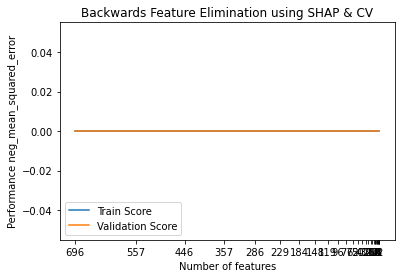

In [158]:
# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=model_xgb, step=0.2, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report = shap_elimination.fit_compute(df_final[COLS], np.log1p(df_final['y']))

# Make plots
performance_plot = shap_elimination.plot()

In [ ]:
report

In [159]:
# Get final feature set
''' num_features는 마지막에 남길 feature 수임. '''
final_features_set = shap_elimination.get_reduced_features_set(num_features=77)

The provided number of features has not been achieved at any stage of the process. You can select one of the following: [402, 322, 258, 207, 166, 133, 107, 86, 69, 56, 45, 36, 29, 24, 20, 16, 13, 11, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [160]:
final_features_set

['04_fr_para61',
 '18_hv_para3',
 '04_date_cos',
 '13_time_para62',
 '13_pressure_para91',
 '12_gas_para36',
 '17_time_para5',
 '12_time_para16',
 '04_position_para72',
 '06_temp_para65',
 '20_time_para83',
 '06_time_para44',
 '12_temp_para11',
 '12_weekday_cos',
 '13_time_para9',
 '04_time_para77',
 '13_tmp_para31',
 '13_time_para37',
 '17_time_para77',
 '13_time_para77',
 '12_temp_para23',
 '18_time_para5',
 '18_time_para83',
 '06_time_para9',
 '20_temp_para55',
 '17_time_para41',
 '13_gas_para73',
 '20_he_para88',
 '18_efem_para25',
 '17_tmp_para31',
 '12_time_para9',
 '20_time_para9',
 '04_temp_para65',
 '12_gas_para50',
 '17_time_para29',
 '18_time_para77',
 '20_temp_para65',
 '20_temp_para93',
 '04_temp_para18',
 '18_time_para42',
 '20_time_para37',
 '12_temp_para87',
 '06_gas_para73',
 '06_gas_para21',
 '12_time_para44',
 '17_he_para88',
 '12_time_para89',
 '17_time_para83',
 '06_power_para76',
 '06_power_para57',
 '12_fr_para28',
 '06_gas_para33',
 '04_temp_para55',
 '13_time_p

# 예측 결과 제출

In [ ]:
df_predict.head()

In [ ]:
pred_X = pd.get_dummies(df_predict[COLS])

In [ ]:
predict['msure_val'] = np.exp(cat.predict(df_predict_final[COLS]))
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

In [ ]:
# 예측값에 결측치가 포함되어 있는지 확인합니다.
df_submission.isnull().sum()

In [ ]:
# 예측값의 갯수가 평가용 데이터의 갯수와 동일한지 확인합니다.
assert len(df_submission) == len(predict)
print(f'No. of Predict DataSet : {len(predict)}\nNo. of Submission DataSet : {len(df_submission)}')

In [ ]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_12.csv')

# module 별 LeaveOneOut으로 모델링해보기

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

In [ ]:
train_idxs = list(df_final.groupby('module_name')['key_val'].nunique().values)
predict_idxs = list(df_predict_final.groupby('module_name')['key_val'].nunique().values)

In [ ]:
cv = LeaveOneOut()
cats = [CatBoostRegressor() for i in range(47)]
for i in range(len(idx)):
    if i==0:
        train_idx = range(idx[i])
    else:
        train_idx = range(idx[i-1], idx[i])
    

scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

In [ ]:
mean(scores)

# Optuna + CatRegressor

In [ ]:
cats = [CatBoostRegressor() for i in range(47)]
idexss = 0
for i,idx in enumerate(train_idxs):
    if i==0:
        train_idx = range(idx)
        idexss += idx
    else:
        train_idx = range(idexss, idexss+idx)
        idexss += idx
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    def objective_CAT(trial):
        param = {
          "random_state":42,
          'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
          'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    #       "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
          "max_depth":trial.suggest_int("max_depth", 4, 12),
          'random_strength' :trial.suggest_int('random_strength', 0, 30),
    #       "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 400),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
          'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
          'task_type':'GPU',
          'devices':'0:7',
          'iterations':100,
          'rsm':1
      }
        X_cat = X
        y_cat = pd.Series(np.log1p(y))
        cv = LeaveOneOut()
        cat = cats[i]
        cat.set_params(**param)
        scores = cross_val_score(cat, X_cat, y_cat, scoring='neg_mean_squared_error',
                                 cv=cv)
        scores = np.sqrt(-scores)

        return np.mean(scores)
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler
    )
    study.optimize(objective_CAT, n_trials=3)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    CAT = CatBoostRegressor(**study.best_params)
    CAT.fit(X, np.log1p(y),verbose=0)
    cats[i] = CAT
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))

In [ ]:
pred = []
idexss_pred = 0
for i, (idx,model) in enumerate(zip(predict_idxs, cats)):
    if i == 0:
        pred_idx = range(idx)
        idexss_pred += idx
    else:
        pred_idx = range(idexss_pred, idexss_pred+idx)
        idexss_pred += idx
    X_pred = df_predict_final.loc[pred_idx, num_features]
    CAT_pred = model.predict(X_pred)
    pred.extend(CAT_pred)

In [ ]:
predict['msure_val'] = np.exp(pred)
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

In [ ]:
len(df_submission)

In [ ]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_15.csv')

# Cat 기본모델과 LooCV

In [ ]:
base_cat_params = {'task_type':'GPU','devices':'0:7','iterations':100,'rsm':1}
cats = [CatBoostRegressor(random_state=1,**base_cat_params) for i in range(47)]
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    
    X_cat = X
    y_cat = pd.Series(np.log1p(y))
    cv = LeaveOneOut()
    cat = cats[i]
    scores = cross_val_score(cat, X_cat, y_cat, scoring='neg_mean_squared_error',
                                cv=cv)
    scores = np.sqrt(-scores)
    print(np.mean(scores))
    
    cat.fit(X, np.log1p(y))
    cats[i] = CAT
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))

In [ ]:
cats = []
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    def objective_CAT(trial):
        param = {
          "random_state":42,
          'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
          'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
    #       "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
          "max_depth":trial.suggest_int("max_depth", 4, 12),
          'random_strength' :trial.suggest_int('random_strength', 0, 30),
    #       "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 400),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
          'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
          'task_type':'GPU',
          'devices':'0:8',
          'iterations':50,
          'rsm':1
      }
        X_cat = X
        y_cat = pd.Series(np.log1p(y))
        loo = LeaveOneOut()
        cat = CatBoostRegressor(**param)
        loo.get_n_splits(X_cat)
        rmsle = []
        for train_idx, test_idx in loo.split(X_cat):
            cat.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:],y_cat.iloc[test_idx])], early_stopping_rounds=15, silent=True)
            cat_pred = cat.predict(X_cat.iloc[test_idx,:])
            rmsle_val = np.sqrt(mean_squared_error(y_cat.iloc[test_idx], cat_pred))
            rmsle.append(rmsle_val)
        return np.mean(rmsle)
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler
    )
    study.optimize(objective_CAT, n_trials=3)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    X_cat = X
    y_cat = pd.Series(np.log1p(y))
    loo = LeaveOneOut()
    CAT = CatBoostRegressor(**study.best_params)
    for train_idx, test_idx in loo.split(X_cat):
            CAT.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:], y_cat.iloc[test_idx])], early_stopping_rounds=15)
    cats.append(CAT)
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))

In [ ]:
import lightgbm as lgb

In [ ]:
cats = []
idexss = 0
for i in range(len(train_idxs)):
    if i==0:
        train_idx = range(train_idxs[i])
        idexss += train_idxs[i]
    else:
        train_idx = range(train_idxs[i-1], idexss+train_idxs[i])
        idexss += train_idxs[i]
    X = df_final.loc[train_idx, num_features]
    y = df_final.loc[train_idx, 'y']
    
    def objective(trial):
        lgbm_param = {
            'objective': 'regression',
            'verbose': -1,
            'metric': 'rmsle', 
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
            'max_depth': trial.suggest_int('max_depth',3, 15),
            'learning_rate': trial.suggest_uniform("learning_rate", 0.01, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
            'random_state':0
        }
        X_cat = X
        y_cat = pd.Series(np.log1p(y))
        loo = LeaveOneOut()
        cat = lgb.LGBMRegressor(**lgbm_param)
        loo.get_n_splits(X_cat)
        rmsle = []
        for train_idx, test_idx in loo.split(X_cat):
            cat.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:],y_cat.iloc[test_idx])], early_stopping_rounds=15, eval_metric='rmse')
            cat_pred = cat.predict(X_cat.iloc[test_idx,:])
            rmsle_val = np.sqrt(mean_squared_error(y_cat.iloc[test_idx], cat_pred))
            rmsle.append(rmsle_val)
        return np.mean(rmsle)
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="lgb_parameter_opt",
            direction="minimize",
            sampler=sampler
    )
    study.optimize(objective, n_trials=3)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    
    X_cat = X
    y_cat = pd.Series(np.log1p(y))
    loo = LeaveOneOut()
    CAT =  lgb.LGBMRegressor(**study.best_params)
    for train_idx, test_idx in loo.split(X_cat):
            CAT.fit(X_cat.iloc[train_idx,:], y_cat.iloc[train_idx], eval_set=[(X_cat.iloc[test_idx,:], y_cat.iloc[test_idx])], early_stopping_rounds=15, eval_metric='rmse')
    cats.append(CAT)
    print('{}번째 모델 훈련이 완료되었습니다.'.format(i+1))